In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import igrins_mod as ig

import glob
import os

import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table, Column, join

from astropy.modeling import models, fitting

from scipy.integrate import trapz
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config Completer.use_jedi = False

# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

# Things that should only have to be defined once, here at the top
---

In [15]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.00001

# Use Normalized (single) Gaussian Distribution
def gaussian_func(x,ampl,center,std,b):
    return ((ampl)/(std*np.sqrt(2*np.pi)) * np.exp(-0.5*((x - center)/std)**2)) + b

In [16]:
# Reduced data in txt files
# Desktop path
data_path = "A:/Documents/Grad_School/Research/IGRINS_Merged"

# Laptop Path
# data_path = "C:/Users/Savio/Documents/GitHub/IGRINS-Spectra/IGRINS_Merged/"
# File path for figures to live in
# Desktop path
fig_path = "A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_figs/standards_spectra/"

# Laptop Path
# fig_path = "C:/Users/Savio/Documents/GitHub/IGRINS-Spectra/IGRINS_figs/standards_spectra/"


# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(data_path+"/merged_standards/m*.fits")
wavelen, flux, snr = ig.get_fitsdata(merged_standard_files[0])


yso_line_dict = {
 'H2 v=2-1 S(5)': 1.944,
 'HeI 16.8': 1.94429,
 'HI 8-4 Brd': 1.9451,
 'H2 v=1-0 S(3)': 1.957,
 'H2 v=3-2 S(7)': 1.969,
 '[Mn II]': 2.00229,
 'H2 v=2-1 S(4)': 2.004,
 '[Ti I]': 2.008516,
 'H2 v=3-2 S(6)': 2.013,
 'H2 v=1-0 S(2)': 2.033,
 'HeI 15-8': 2.03788,
 'HeI 1P-1': 2.0567,
 'He I 2.05': 2.05869,
 'H2 v=3-2 S(5)': 2.065,
 'H2 v=2-1 S(3)': 2.073,
 'HeI 3S-3': 2.1126,
 'H2 v=1-0 S(1)': 2.121,
 'H2 v=3-2 S(4)': 2.128,
 'H2 v=2-1 S(2)': 2.154,
 'HeI 14-8': 2.16523,
 'HI 7-4 Brg': 2.1661,
 'HeI 10-7': 2.18911,
 'H2 v=3-2 S(3)': 2.201,
 'H2 v=4-3 S(5)': 2.201,
 '[Fe III]': 2.2184,
 'H2 v=1-0 S(0)': 2.223,
 'H2 v=2-1 S(1)': 2.247,
 'H2 v=5-4 S(7)': 2.251,
 'H2 v=4-3 S(4)': 2.266,
 '[Fe II]': 2.28573,
 'H2 v=3-2 S(2)': 2.287,
 'CO 2-0': 2.2935,
 'CO 3-1': 2.3227,
 'H2 v=4-3 S(3)': 2.344,
 'HI 30-5': 2.34455,
 'HeI 13-8': 2.34703,
 'HI 29-5': 2.34926,
 'CO 4-2': 2.3525,
 'HI 28-5': 2.3545,
 'H2 v=2-1 S(0)': 2.355,
 'H2 v=5-4 S(5)': 2.355,
 'HI 27-5': 2.36037,
 'HI 26-5': 2.36696,
 'HI 25-5': 2.3744,
 'HeI 19-9': 2.37945,
 'HI 24-5': 2.38284,
 'CO 5-3': 2.3829,
 'H2 v=3-2 S(1)': 2.386,
 'HI 23-5': 2.39249,
 'HI 22-5': 2.40357,
 'H2 v=1-0 Q(1)': 2.406,
 'H2 v=1-0 Q(2)': 2.413,
 'CO 6-4': 2.4142,
 'HI 21-5': 2.4164,
 'H2 v=1-0 Q(3)': 2.423,
 'HI 20-5': 2.43138,
 'H2 v=1-0 Q(4)': 2.437,
 'CO 7-5': 2.4461,
 'HI 19-5': 2.44902,
 'H2 v=1-0 Q(5)': 2.454,
 'HeI 18-9': 2.46074,
 '[Fe II]??': 2.467565,
 'HI 18-5': 2.47001,
 'H2 v=1-0 Q(6)': 2.475,
 'CO 8-6': 2.4787,
 'HI 17-5': 2.49527,
 'H2 v=3-2 S(0)': 2.501,
 '[Co II][Ni VI]': 2.5308,
 'Ne II ??': 2.55066,
 'Fe I (C I?)': 2.58404,
 '[Co IV]': 2.5932,
 '[V I]': 2.59823,
 '[Cu IV]': 2.5983,
 'Fe I 2.60': 2.6037869,
 'HI 6-4 Brb': 2.6259,
 '[Cr III][V II]': 2.62623,
 '[Ni IV]': 2.7181,
 'He I 2.75': 2.75704,
 '[Fe IV]': 2.8063,
 '[Sc I]': 2.96879,
 'H2 v=2-1 O(4)': 3.189}

yso_line_dict = dict(sorted(yso_line_dict.items(), key=lambda item: item[1]))

# Strings of the lines
ysolines_str = list(yso_line_dict.keys())

# Wavelength values for each line
ysolines_wav = np.array(list(yso_line_dict.values()))

ysolines_wav = ysolines_wav[(ysolines_wav > wavelen.min()) & (ysolines_wav < wavelen.max())]

# NIR Lines in micron
nir_dict = {
    "Fe-2.084"  :   2.084088,
    "Si-2.092"	:   2.092,
    "Mg-2.106"	:	2.106,
    "Al-2.11"	:	2.11,
    "Ca-2.2035"	:	2.2035,
    "Fe-2.2037"	:	2.2037,
    "Sc-2.2052"	:	2.2052,
    "Na-2.2052"	:	2.2052,
    "Si-2.2063"	:	2.2063,
    "Sc-2.2065"	:	2.2065,
    "Si-2.2073"	:	2.2073,
    "Fe-2.2079"	:	2.2079,
    "Na-2.2083"	:	2.2083,
    "Ca-2.2113"	:	2.2113,
    "Br-Gamma"  :   2.1655,
    "Ti-2.2218"	:	2.2218,
    "Ti-2.224"	:	2.22397,
    "Fe-2.226"	:	2.226,
    "Ti-2.228"	:	2.228,
    "Ti-2.232"	:	2.232,
    "Ca-2.26573":	2.26573,
    "Fe-2.2742"	:	2.2742,
    "Mg-2.281"	:	2.281,
    "Ca-2.2825"	:	2.2825,
    "Fe-2.284"	:	2.284,
    "Ti-2.29"	:	2.29,
    "Ti-2.297"	:	2.297
}
# The CO Overtones will be an interesting challenge I'm sure
    # "CO(2-0)-2.29353" :	2.29353,
    # "CO(2-0)-2.32265"	:	2.32265,
    # "CO(2-0)-2.34327" :	2.34327,
    # "CO(2-0)-2.34531" :	2.34531,
    # "CO(2-0)-2.3495" 	:	2.3495,
    # "CO(2-0)-2.35167"	:	2.35167,
    # "CO(2-0)-2.35246" :	2.35246,
    # "CO(2-0)-2.38295" :	2.38295,
    # }

# Strings of the Nir lines
lines_str = list(nir_dict.keys())

# Wavelength values for each NIR line
lines_wav = np.array(list(nir_dict.values()))

# Just a list of the elemental shorthand symbols
labels = [string.split('-')[0] for string in lines_str]

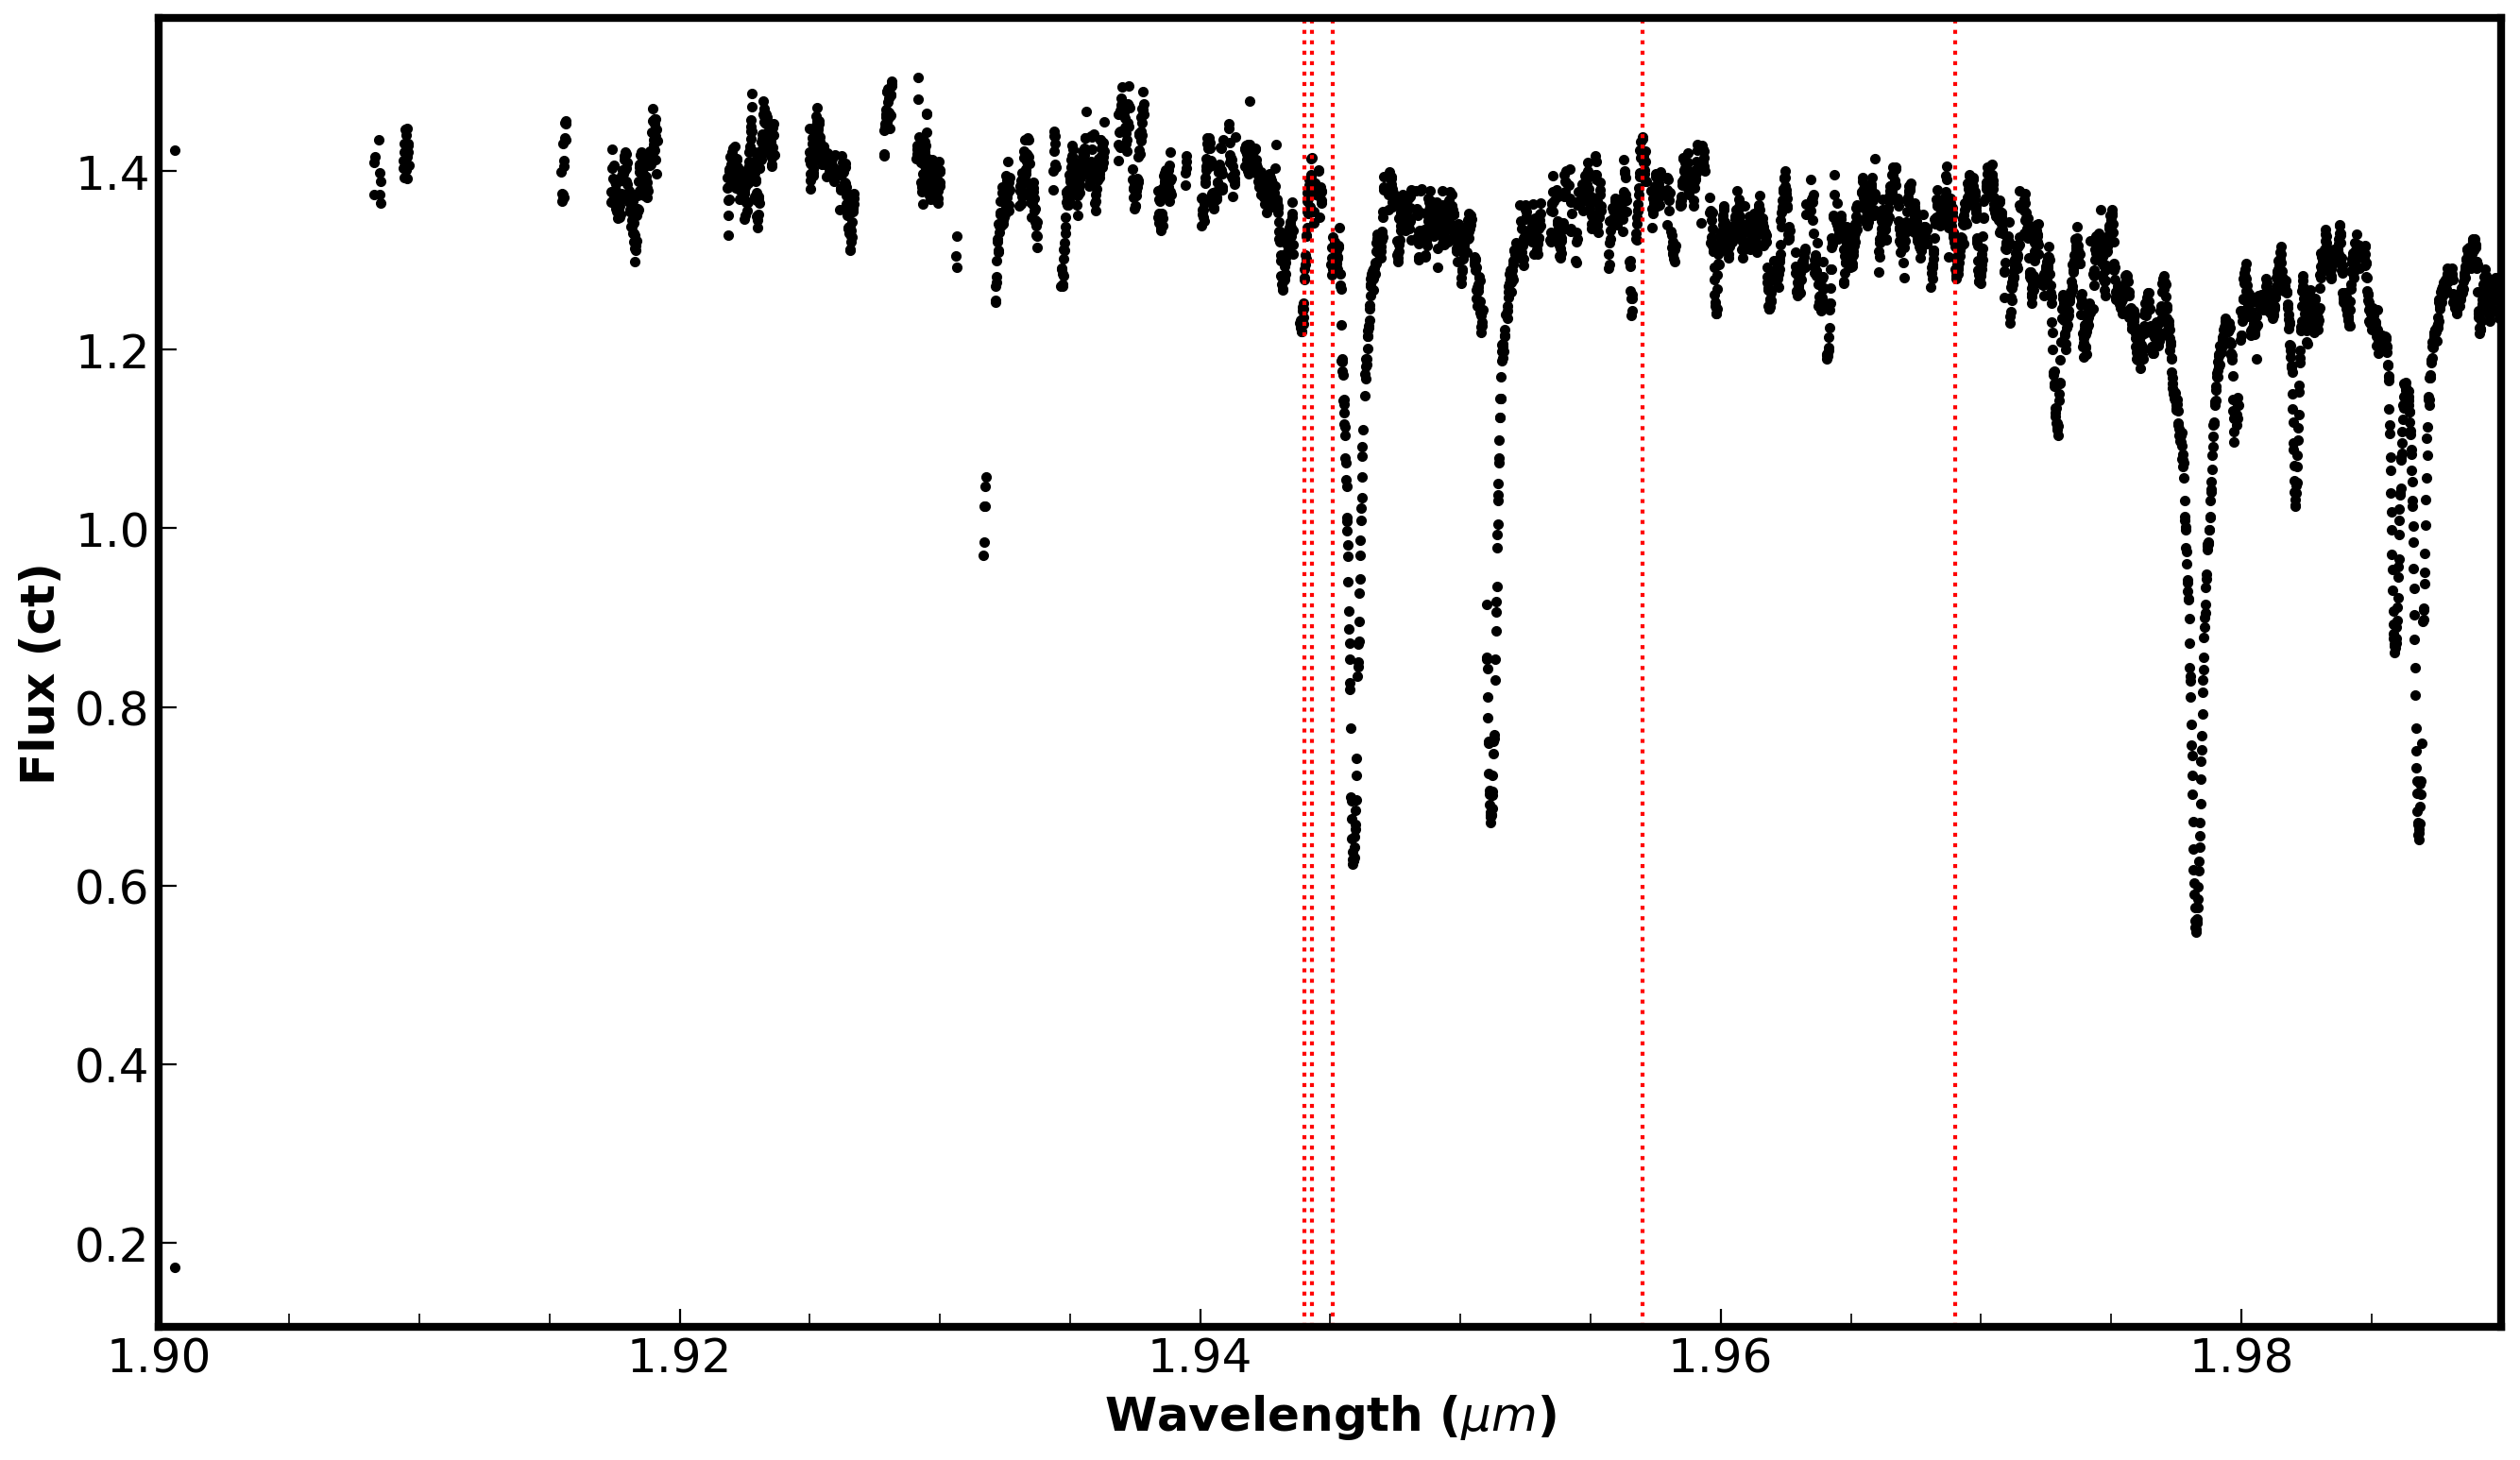

In [17]:
norm_flux = ig.normalize_flux(flux)

plt.figure(figsize=(16,9))

# plt.plot(wavelen,flux,'.',mec='black')
plt.plot(wavelen,norm_flux,'.',mfc='black',mec='black')


for i in range(len(lines_wav)):
    plt.axvline(lines_wav[i],ls=':',c='red')
    plt.axvline(ysolines_wav[i],ls=':',c='red')
    # plt.xlim(lines_wav[i]-10*spec_res,lines_wav[i+1]+10*spec_res)

plt.xlim(1.9,1.99)
# plt.ylim(0,1.55)

plt.xlabel('Wavelength ({})'.format('$\mu m$')) 
plt.ylabel('Flux ({})'.format("ct")) 

plt.show()

# Gaussian Fitting
---

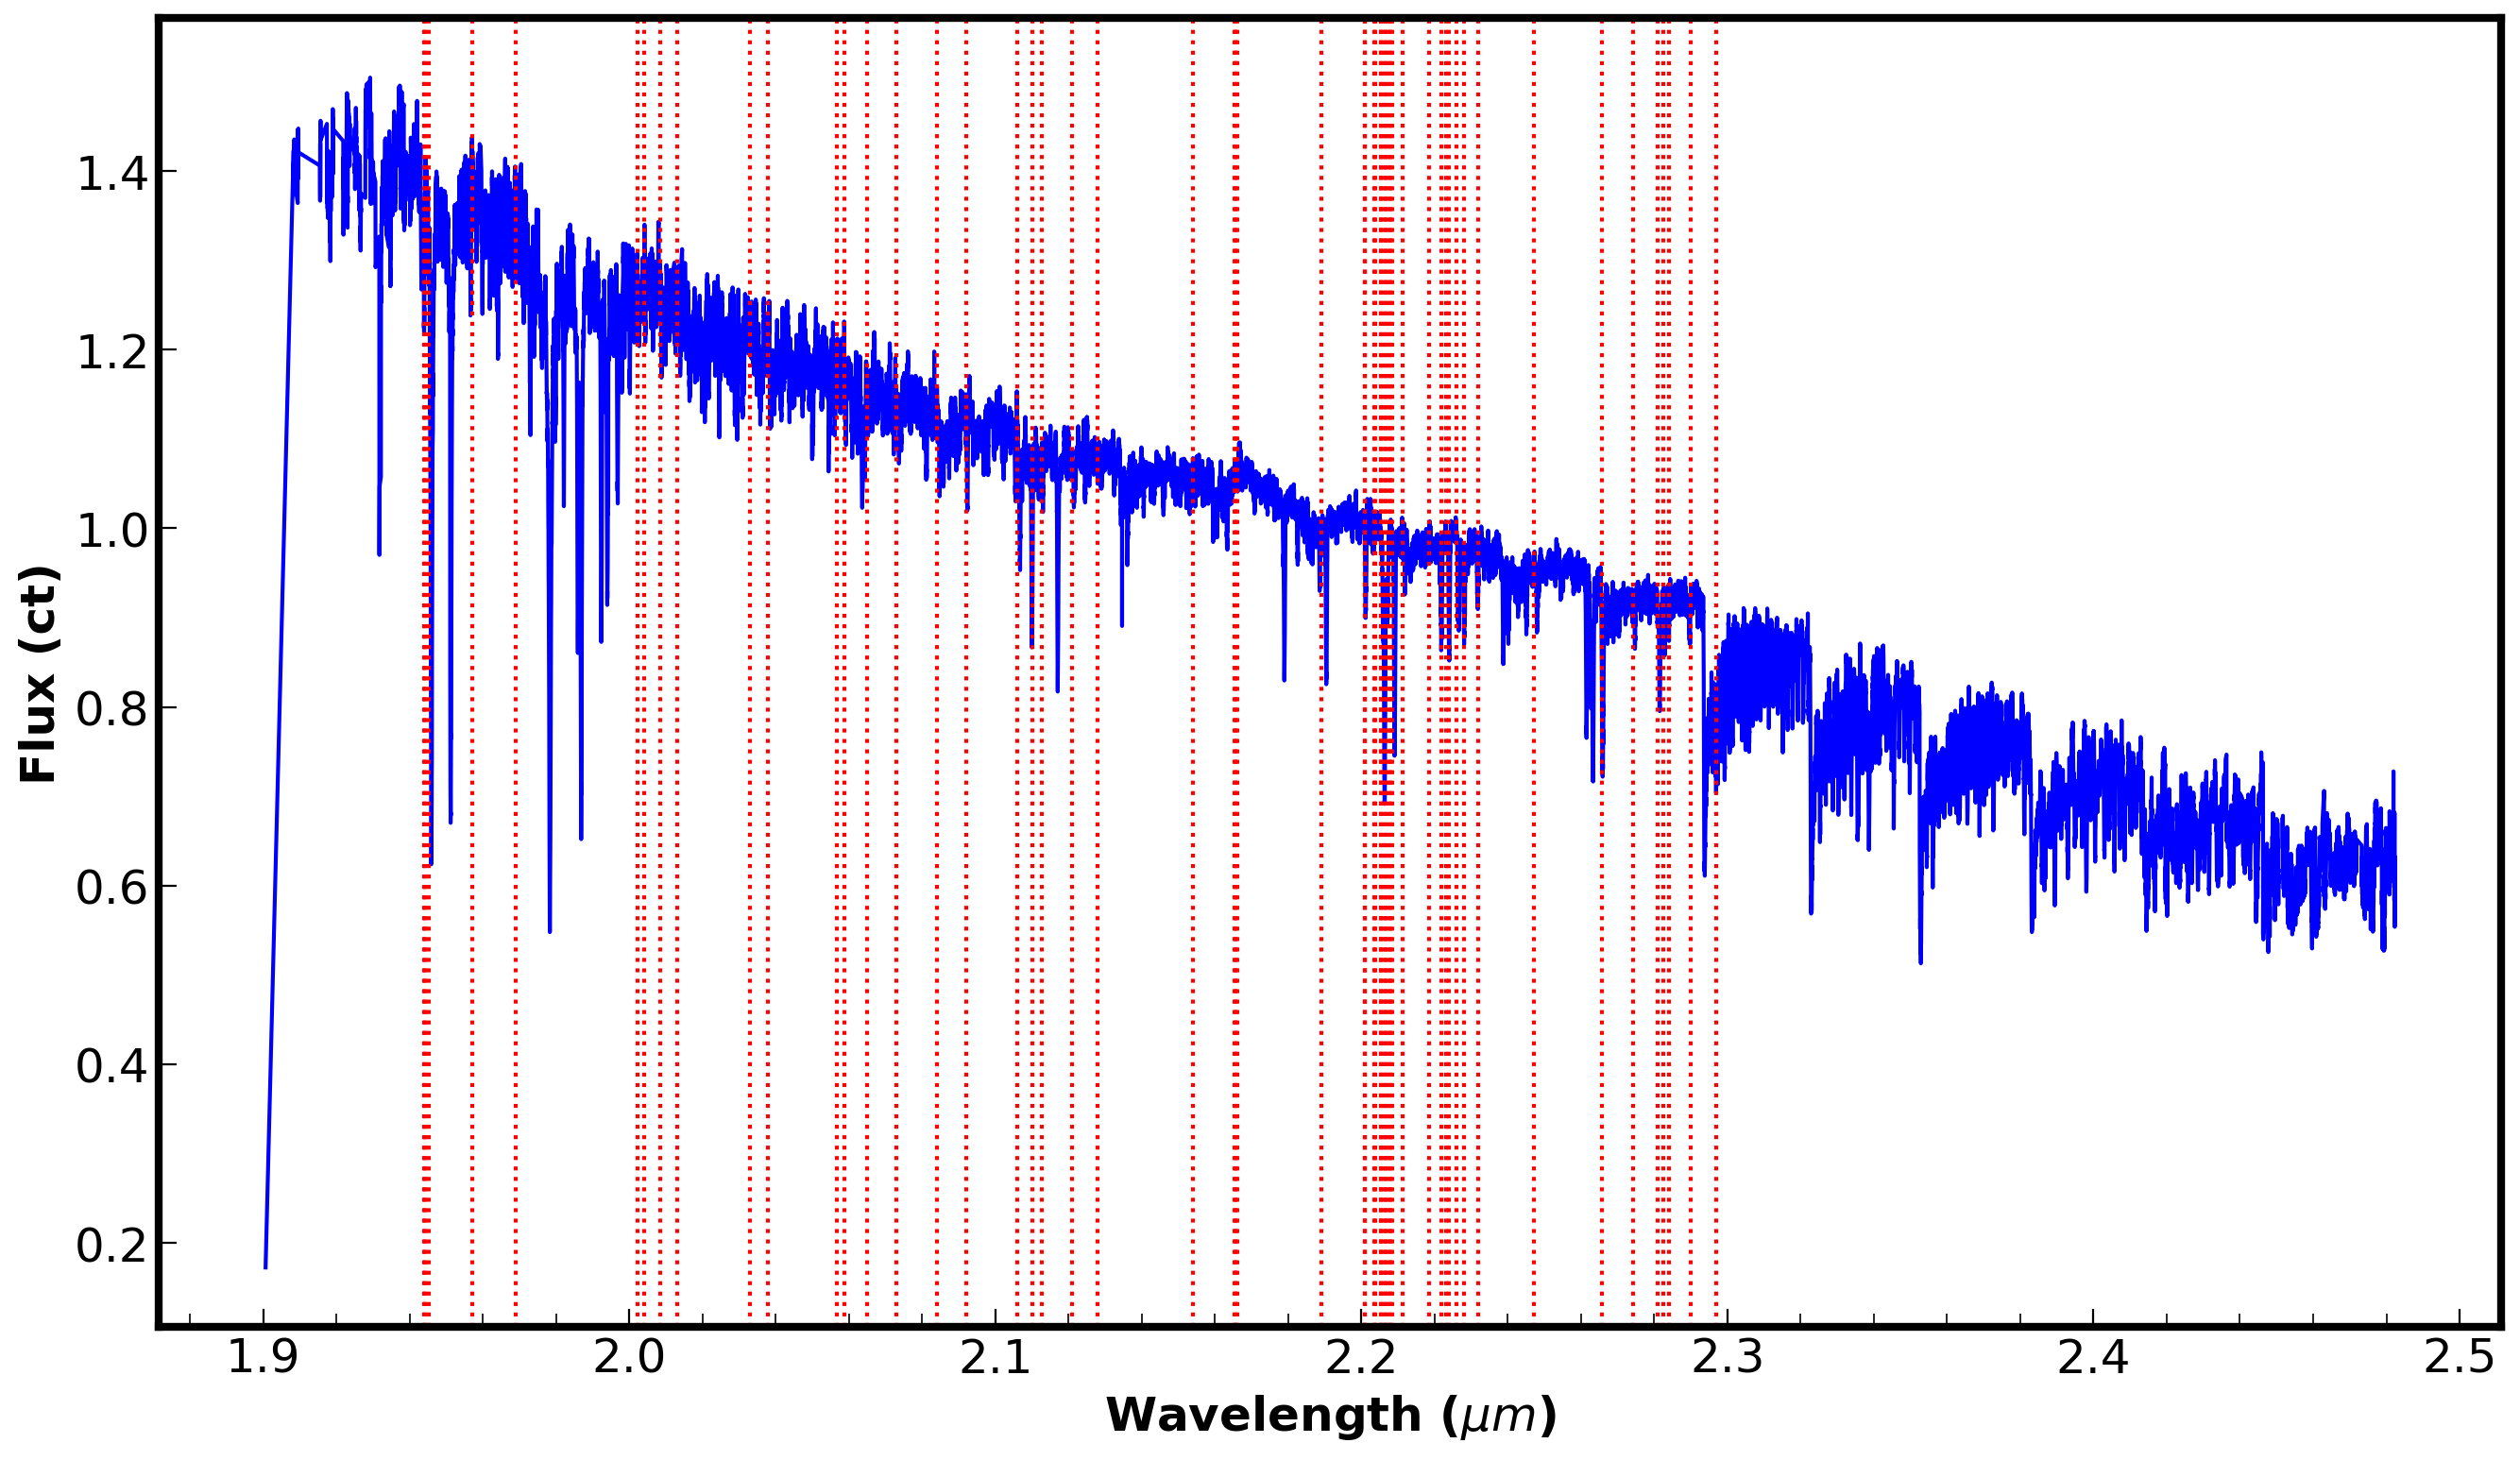

In [18]:
plt.figure(figsize=(16,9))

# plt.plot(wavelen[wavelen > 2.0],norm_flux[wavelen > 2.0],'-',color='black')
plt.plot(wavelen[wavelen > wavelen.min()],norm_flux[wavelen < wavelen.max()],'-',color='blue')
# plt.plot(wavelen[wavelen > wavelen.min()],cont_norm[wavelen < wavelen.max()],'-',color='red')

for i in range(len(lines_wav)):
    plt.axvline(lines_wav[i],ls=':',c='red')
    plt.axvline(ysolines_wav[i],ls=':',c='red')
    # plt.xlim(lines_wav[i]-10*spec_res,lines_wav[i+1]+10*spec_res)

# plt.xlim(1.9,2.0)
# plt.ylim(0,1.55)

plt.xlabel('Wavelength ({})'.format('$\mu m$')) 
plt.ylabel('Flux ({})'.format("ct")) 

plt.show()

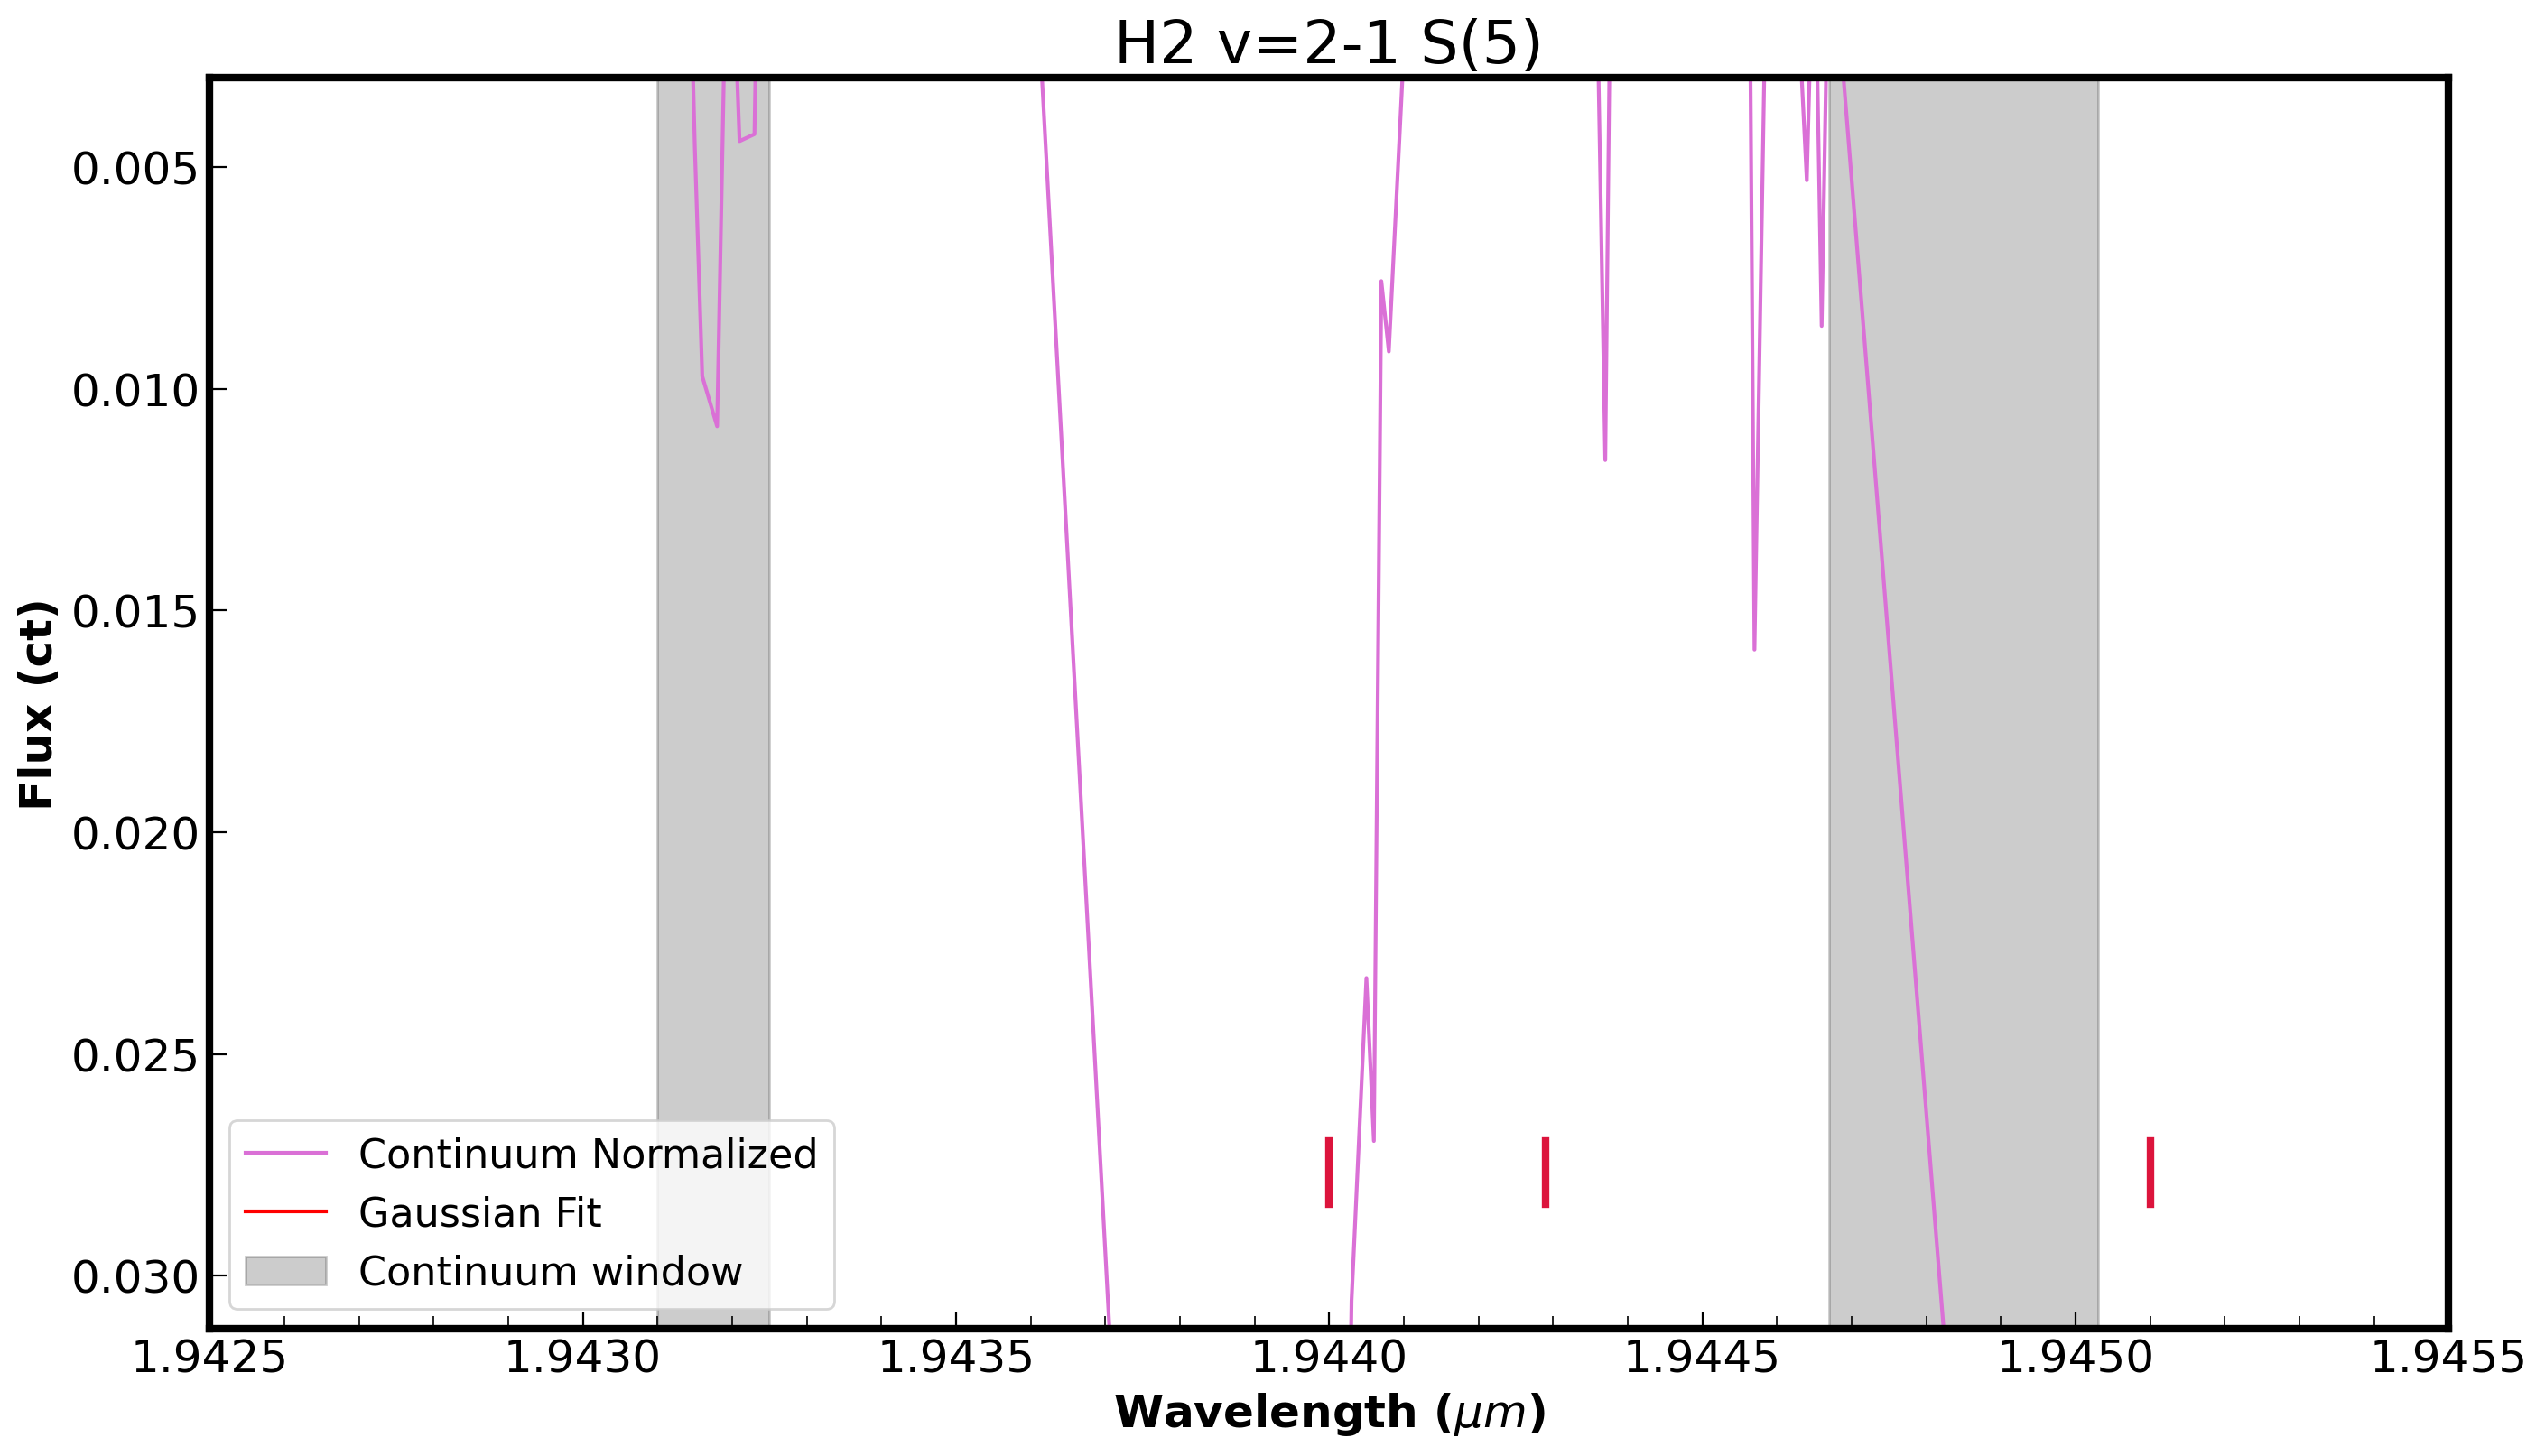

[-0.29120266  2.47865     0.7980846   0.45971124]


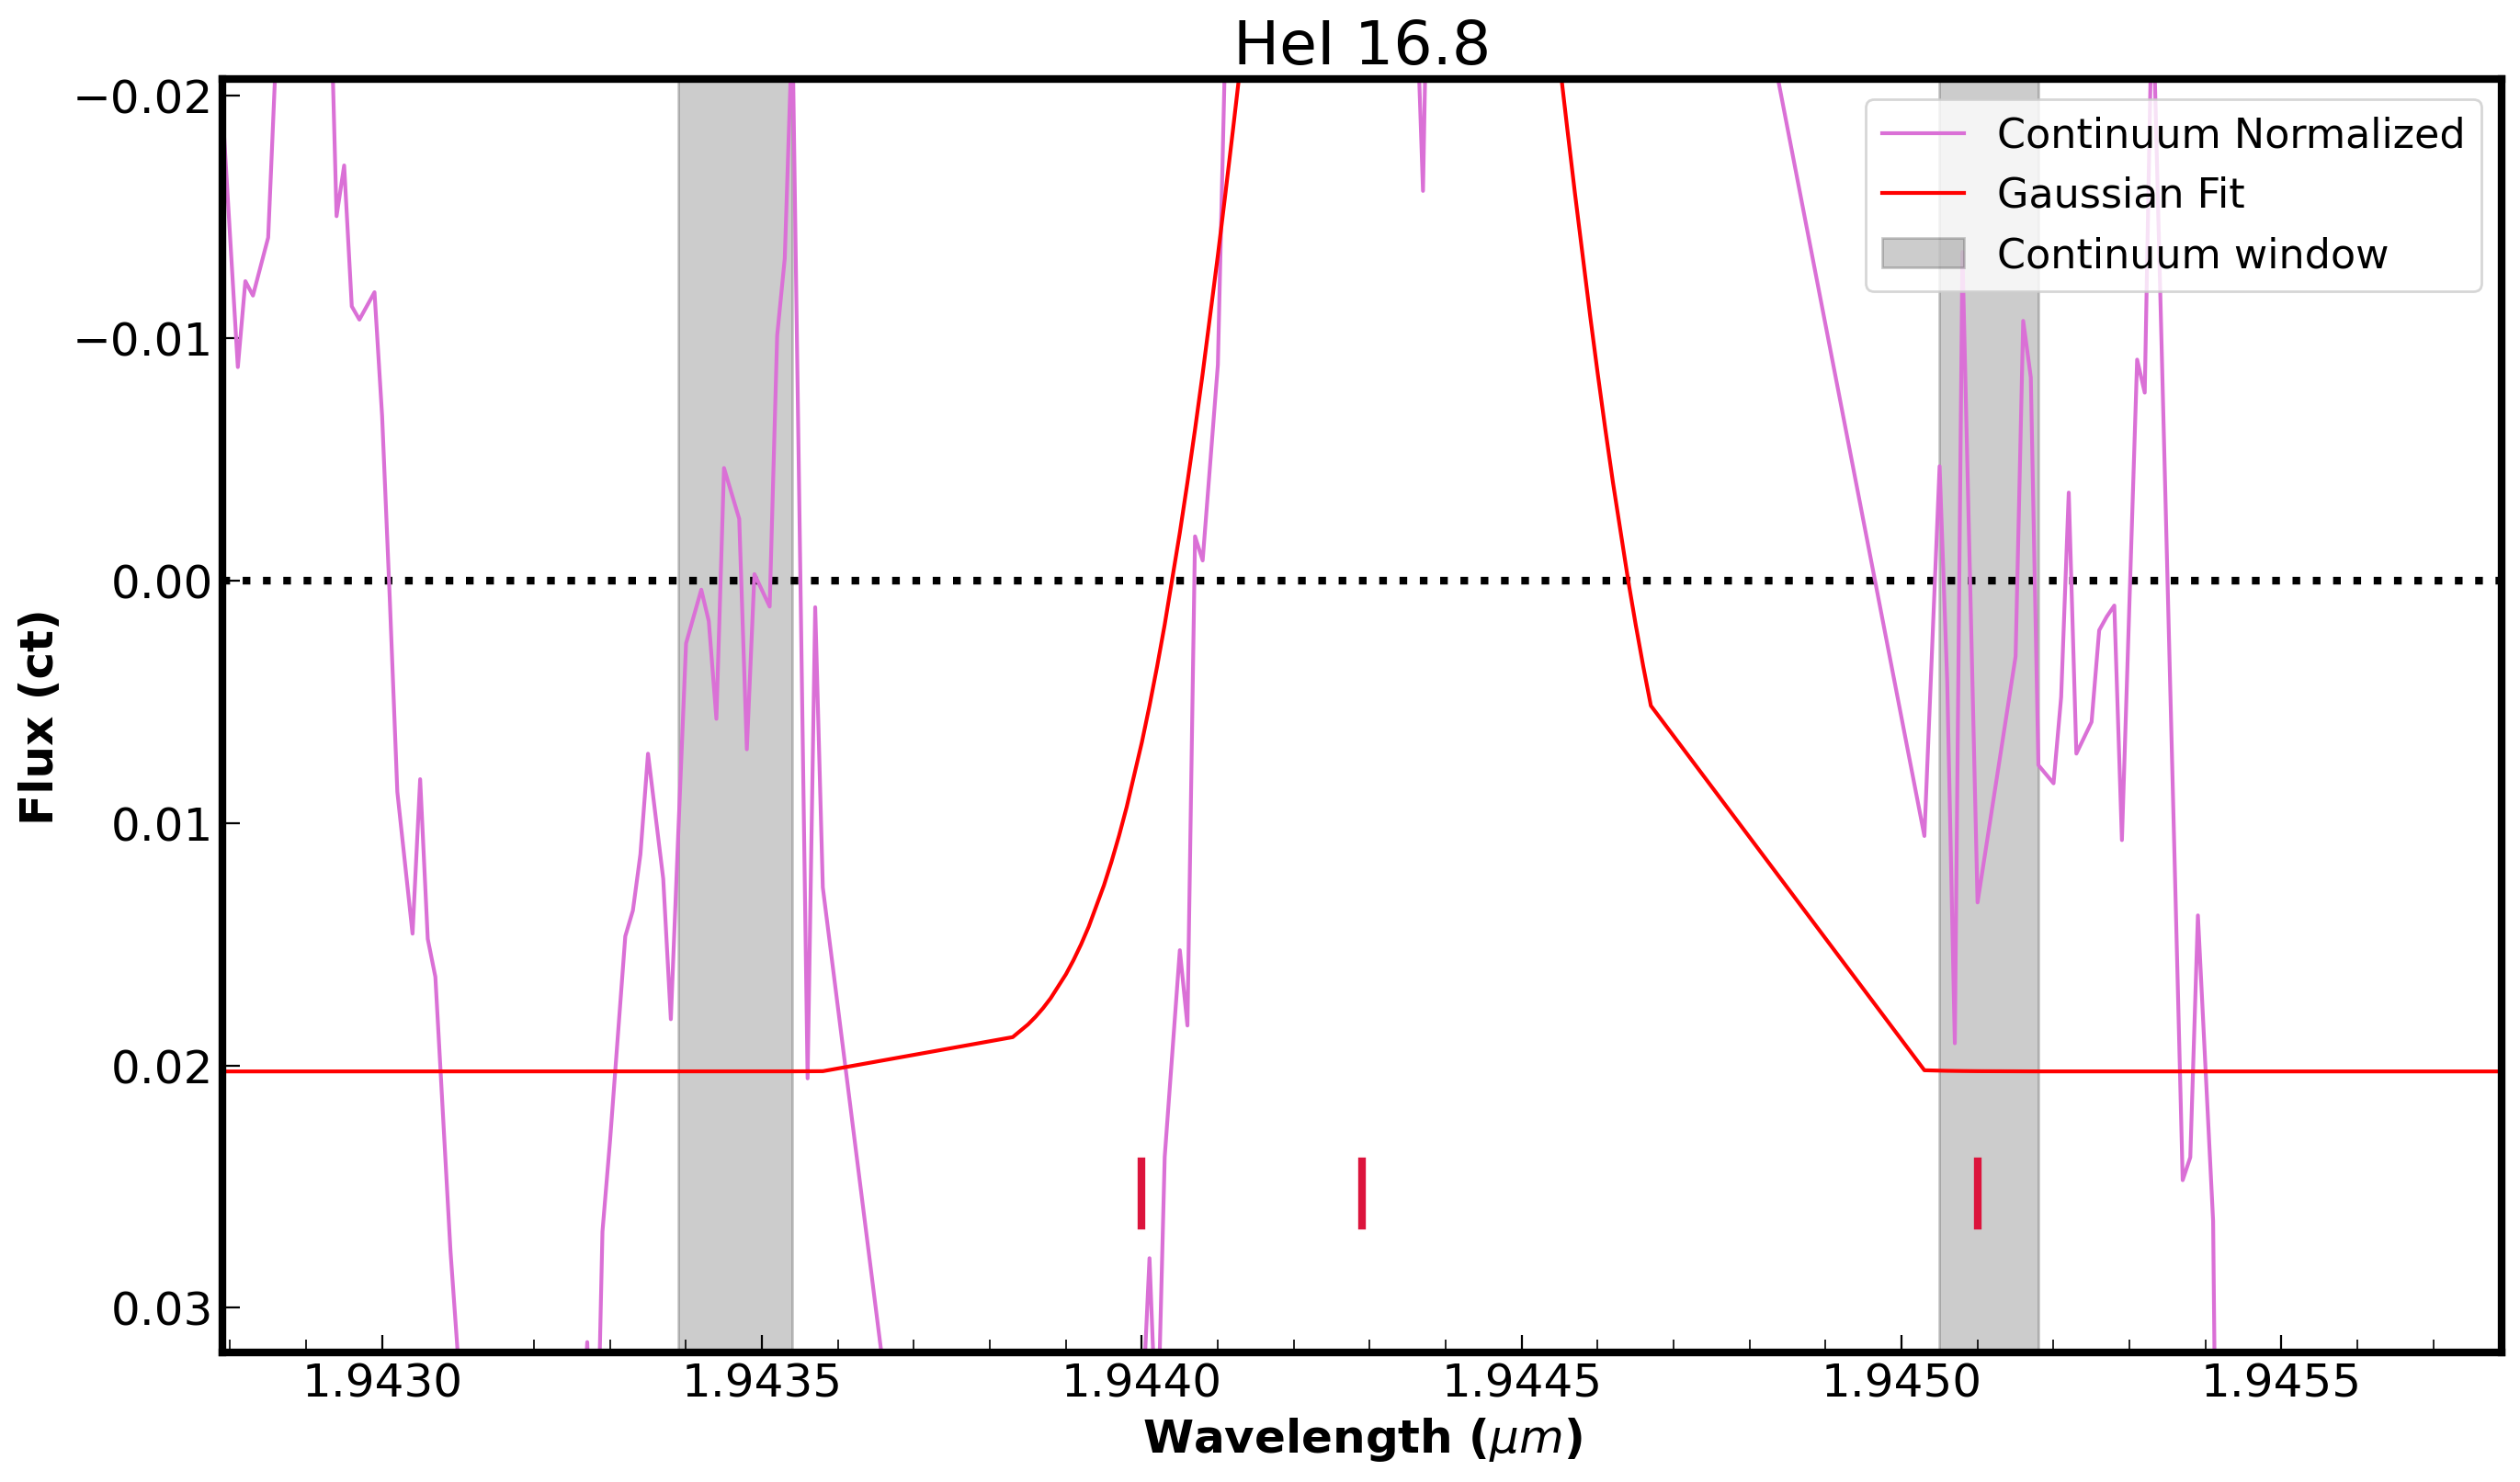

[-0.29120266  2.47865     0.7980846   0.45971124]


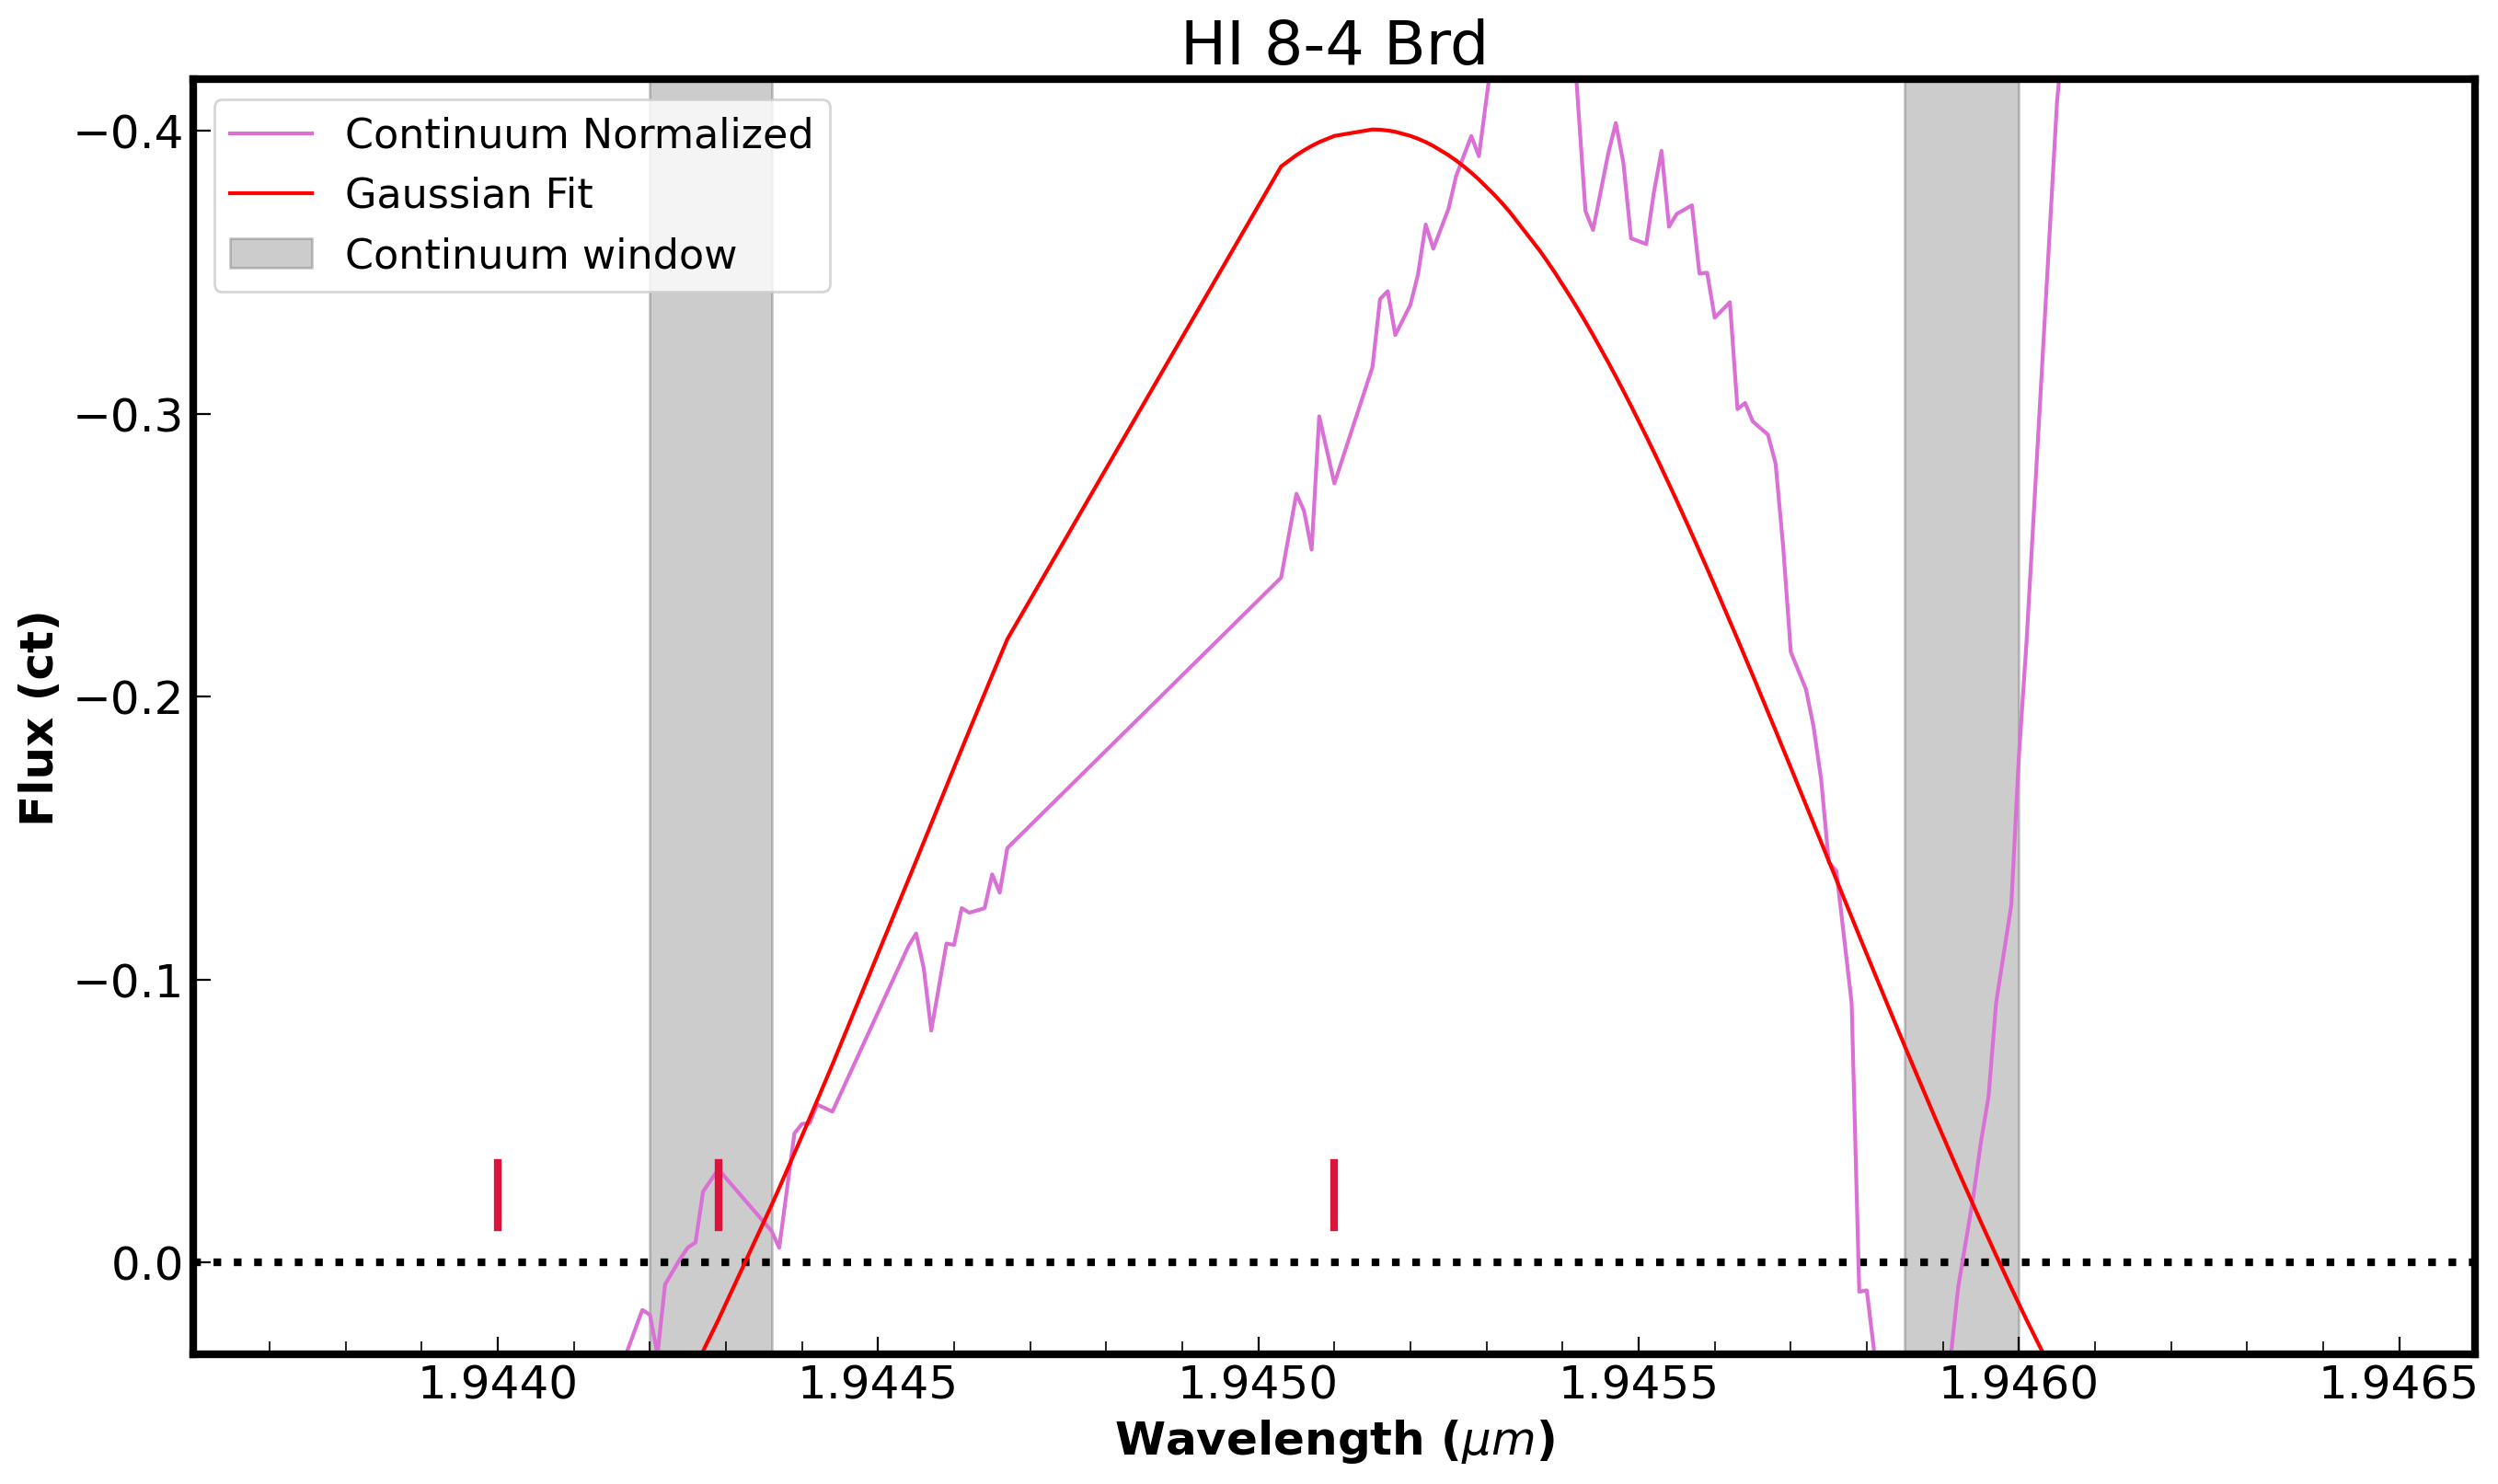

[-0.29120266  2.47865     0.7980846   0.45971124]


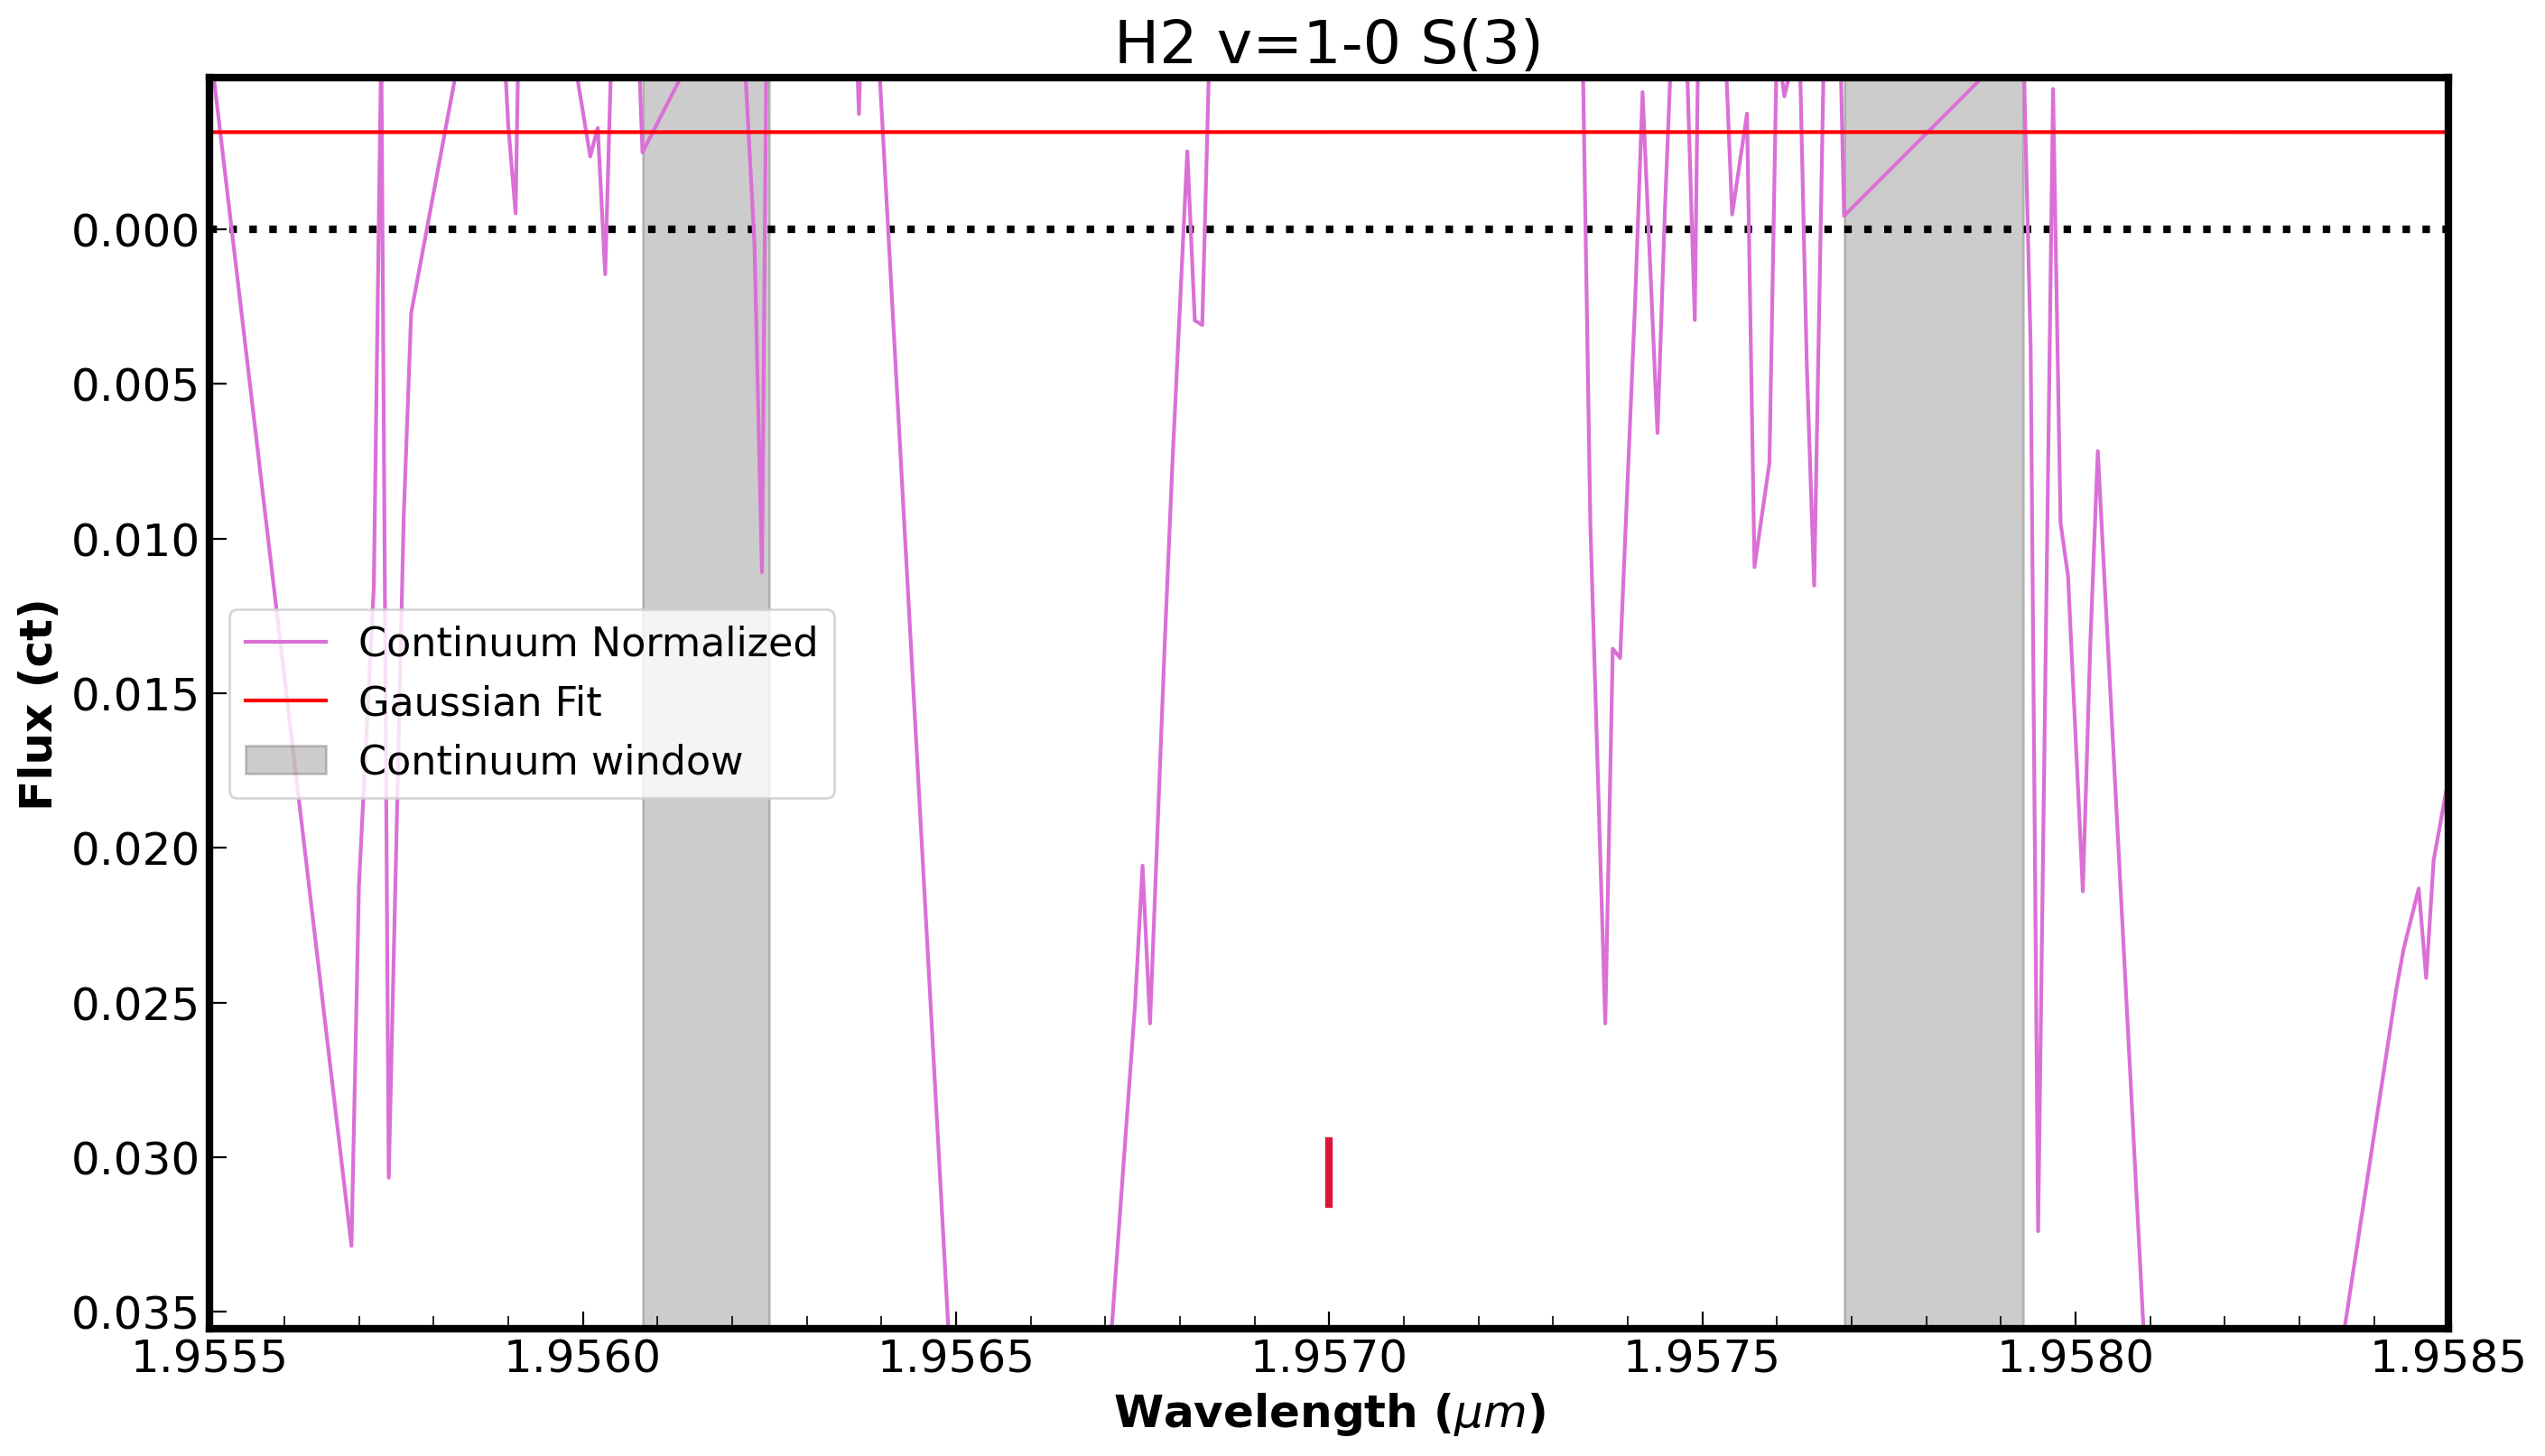

[-0.29120266  2.47865     0.7980846   0.45971124]


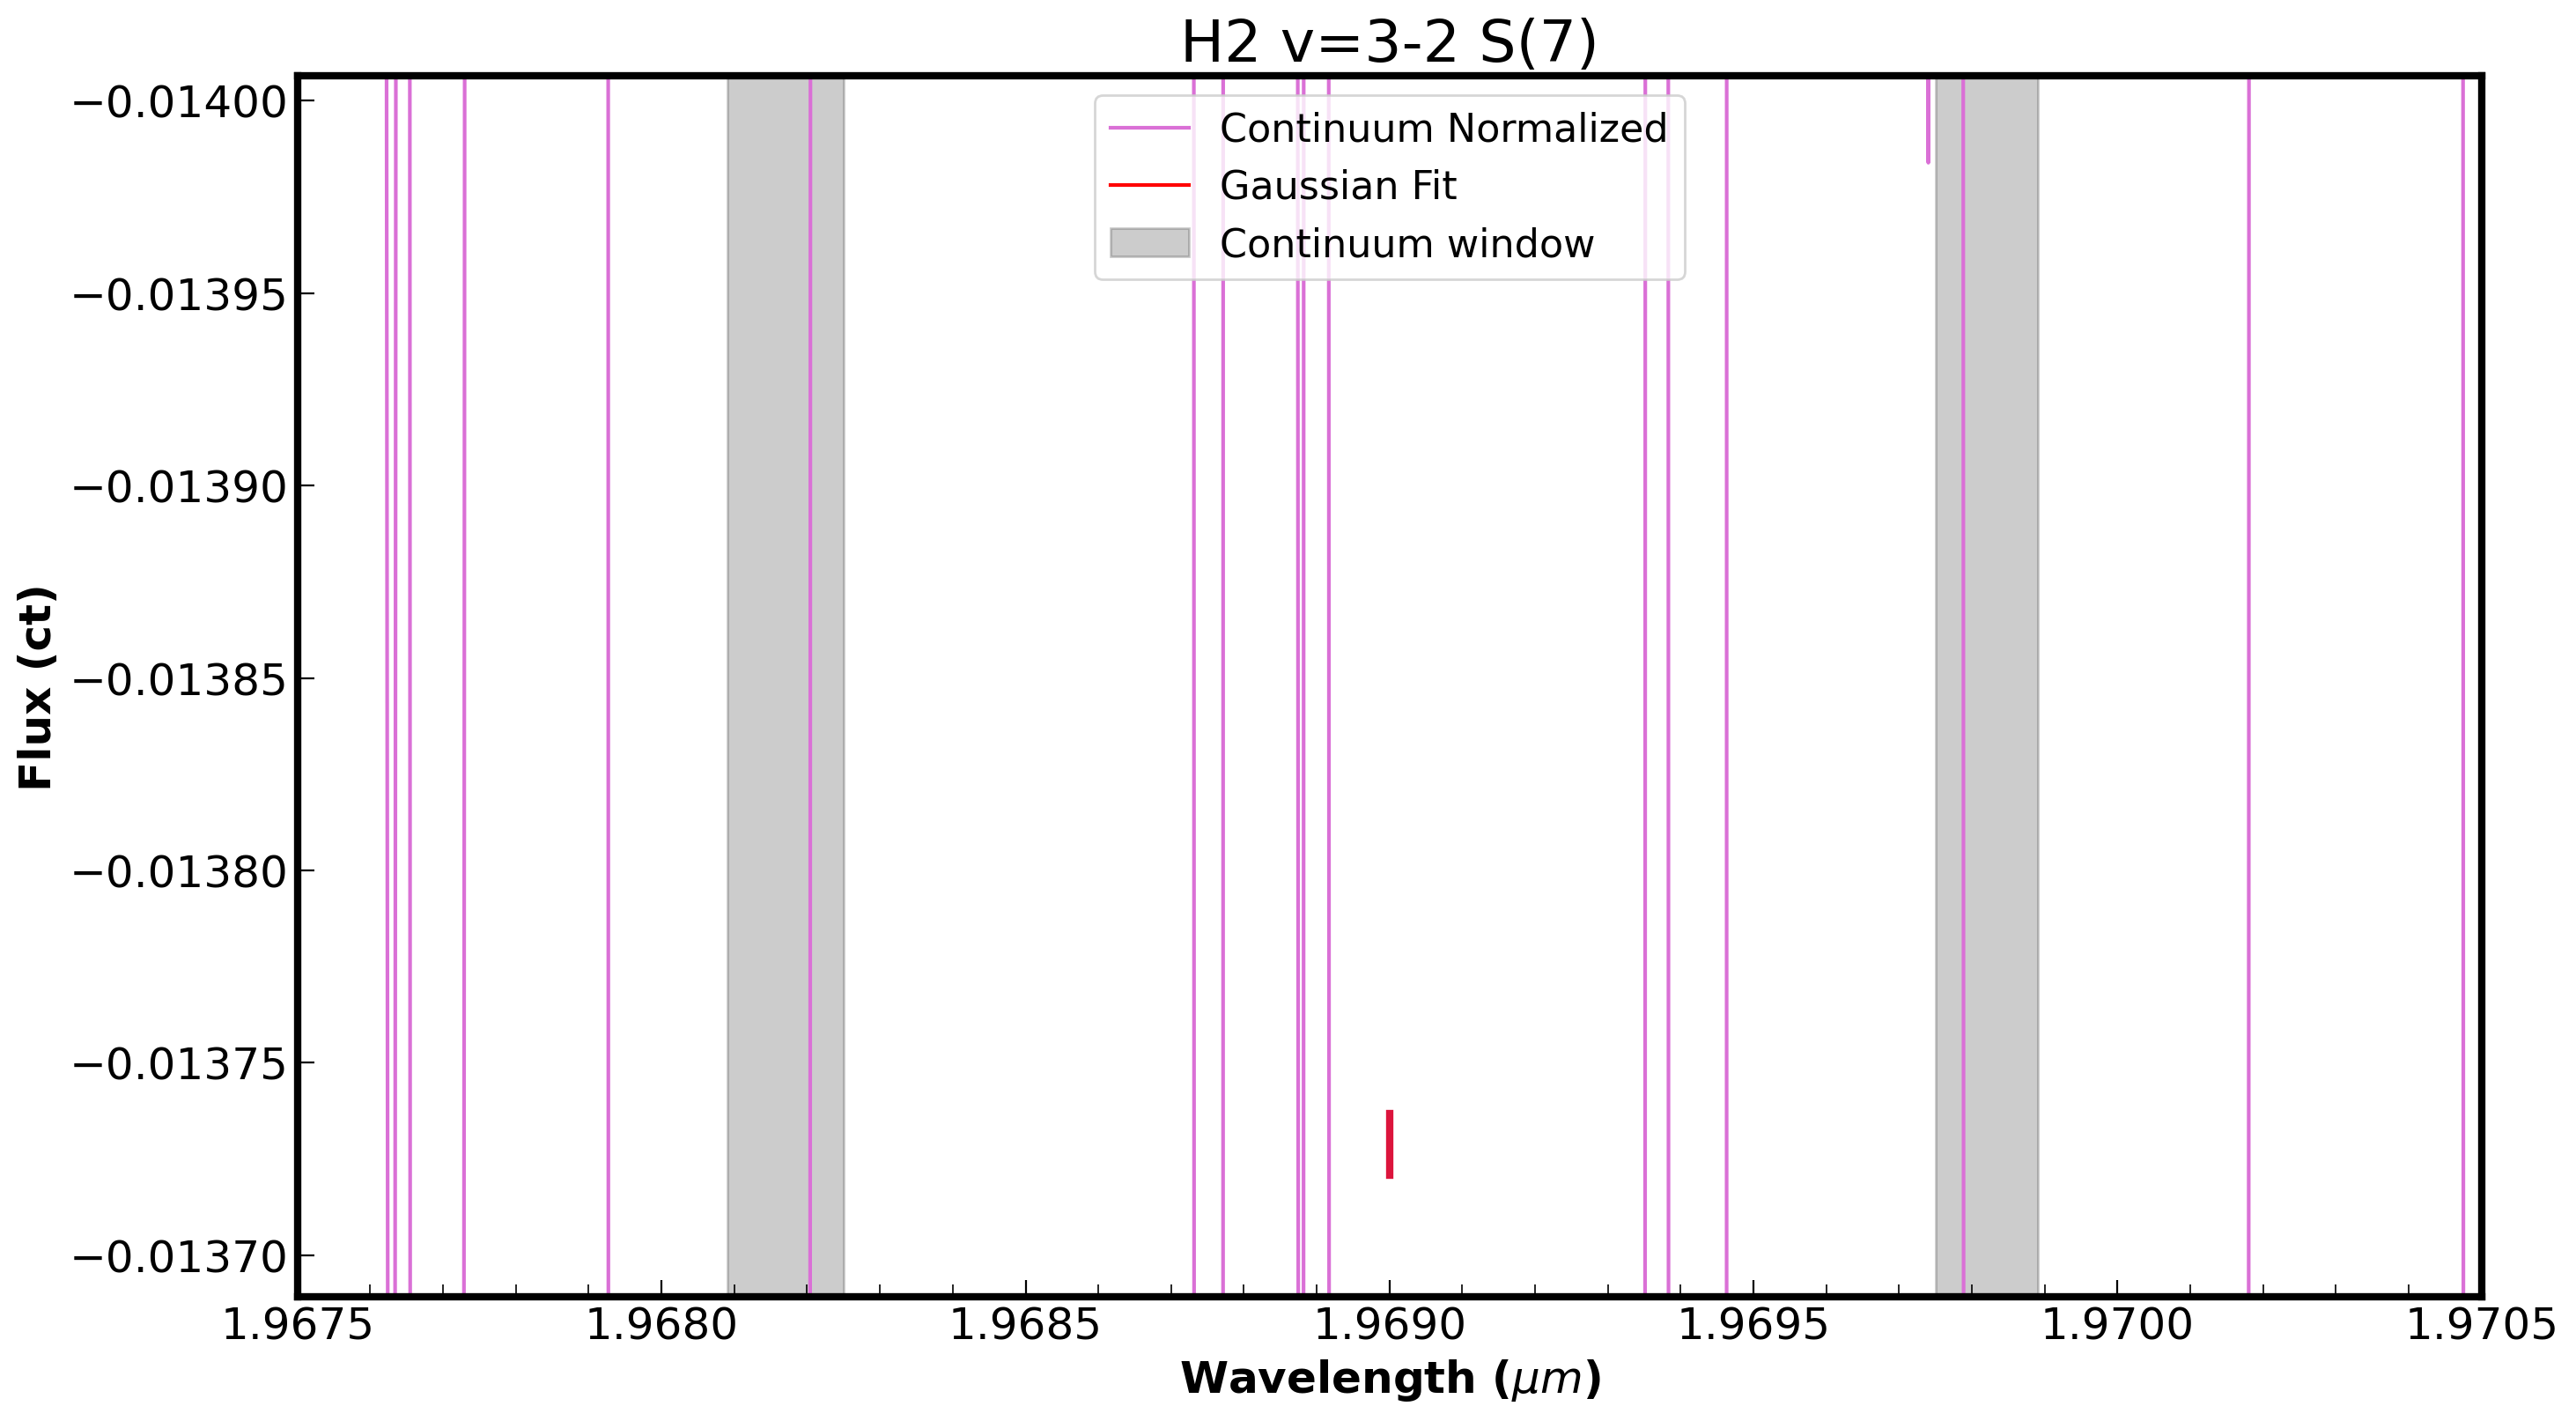

[-0.29120266  2.47865     0.7980846   0.45971124]


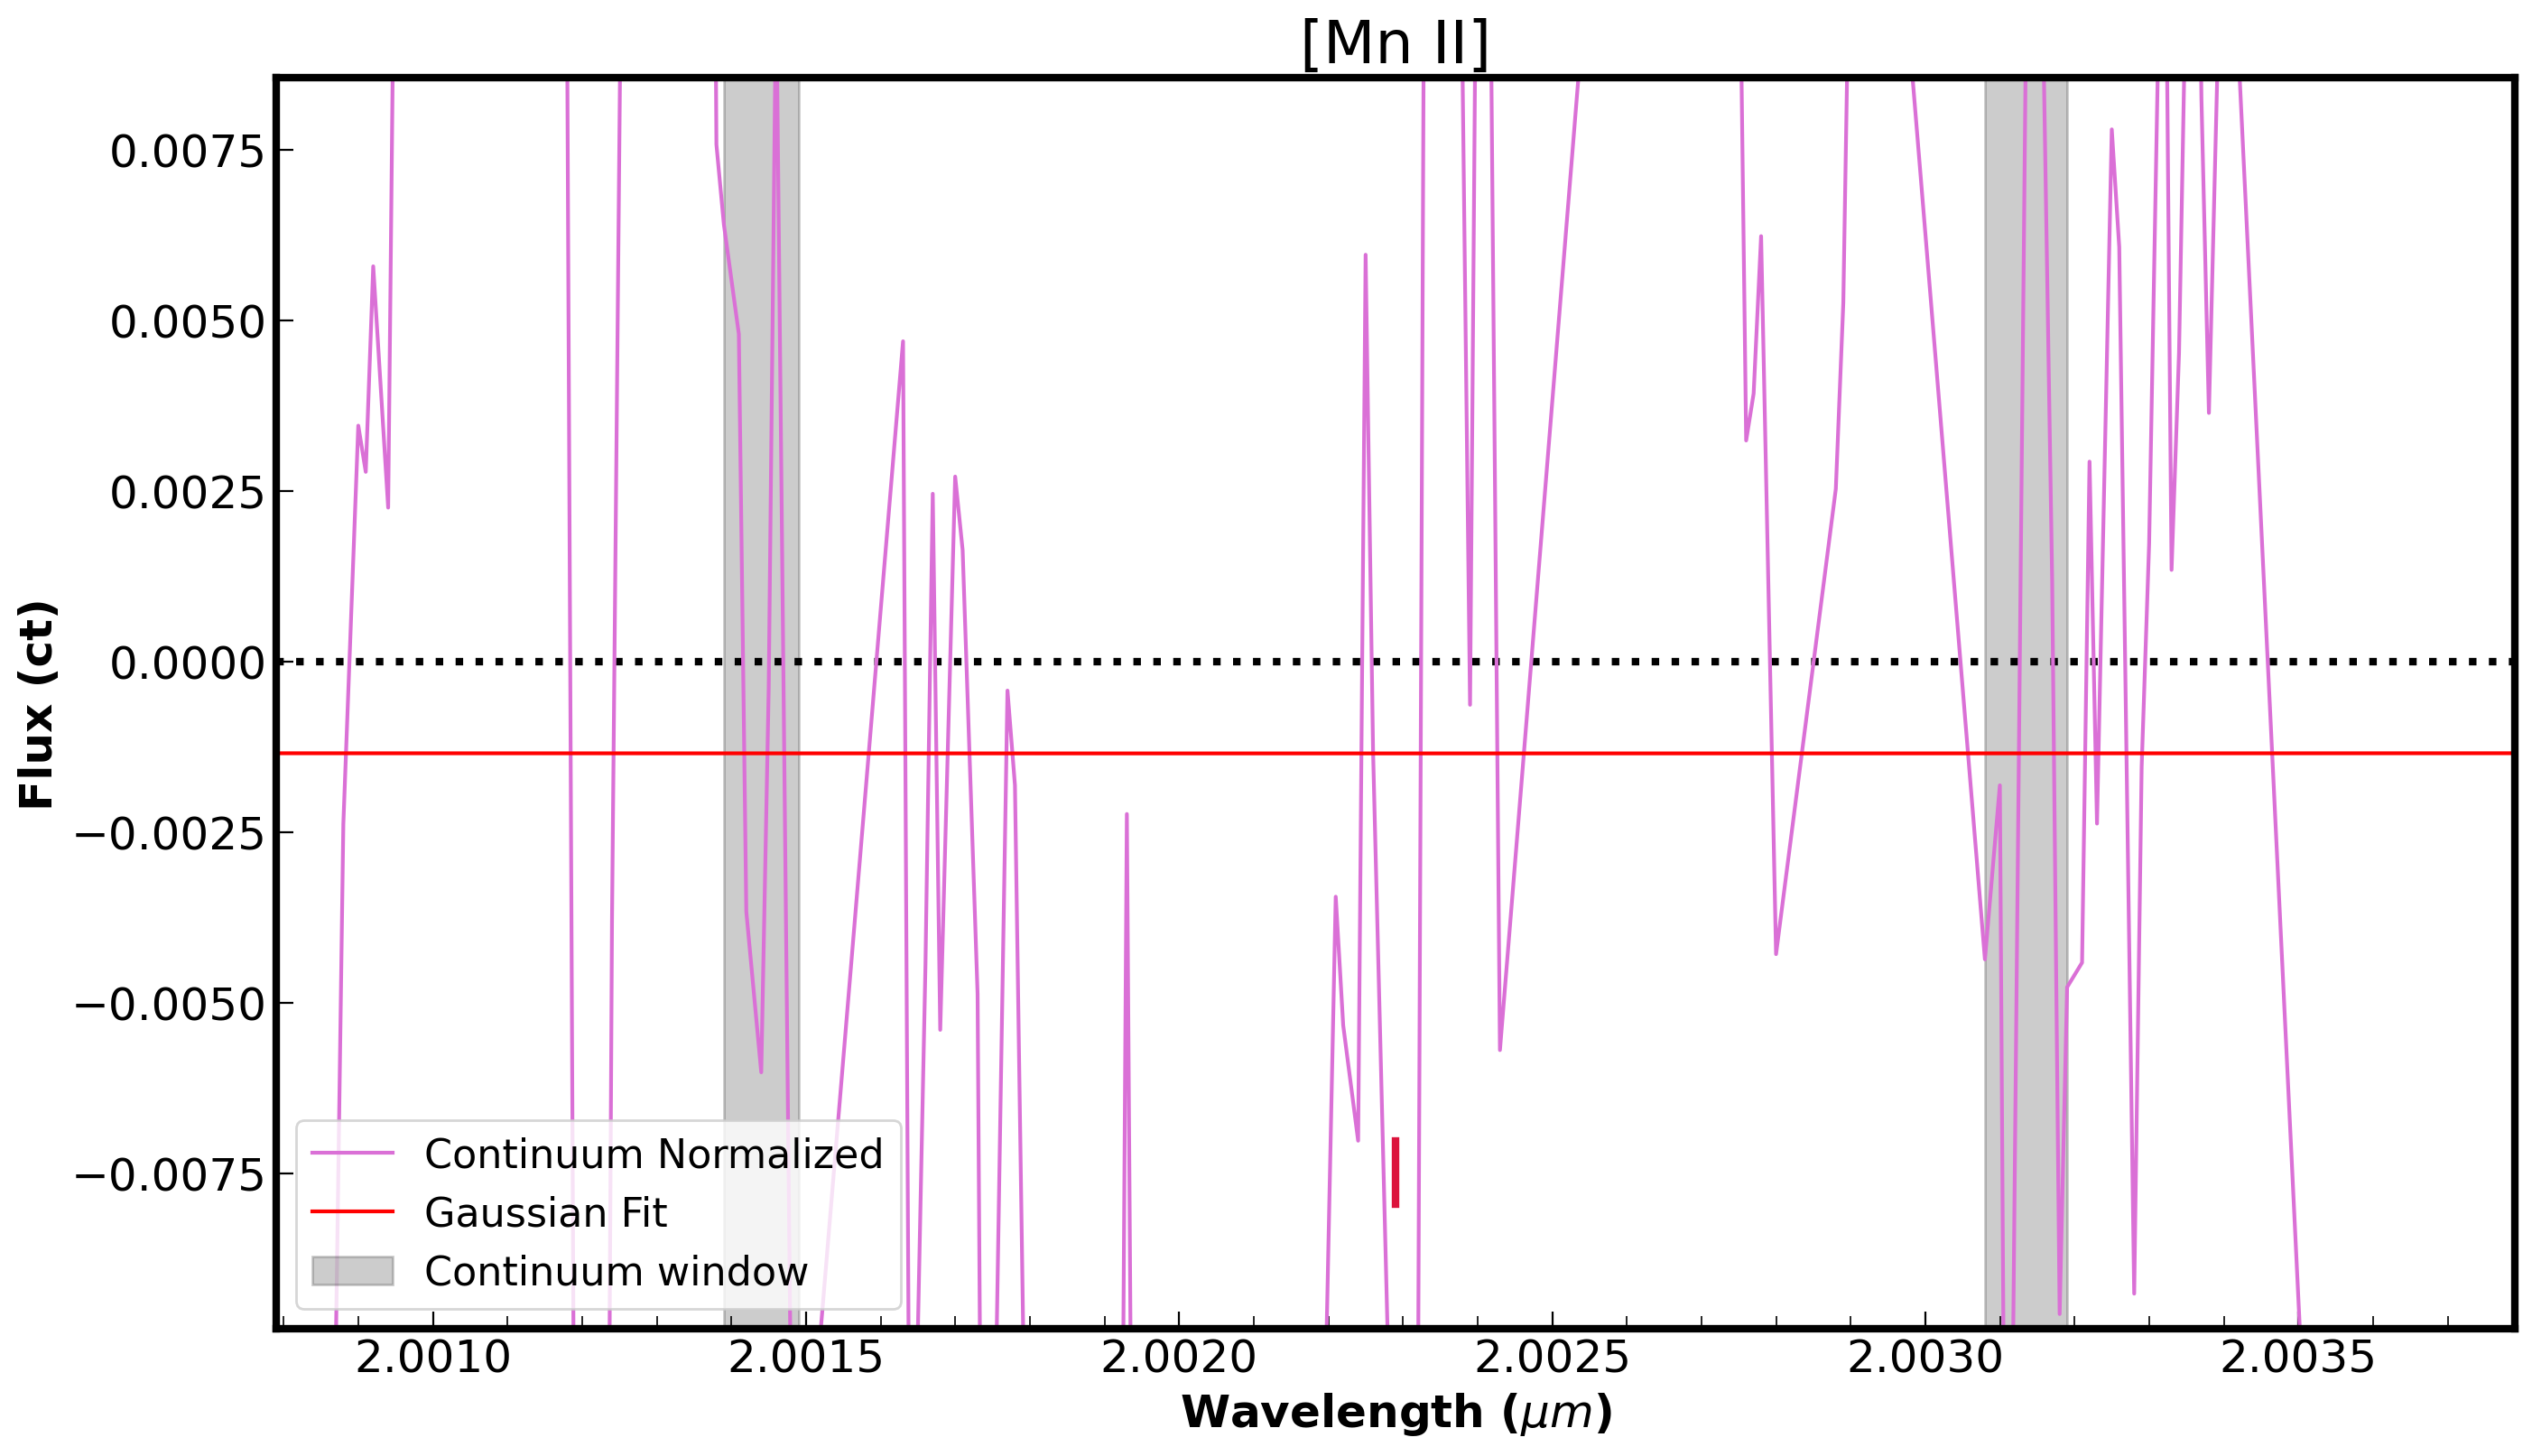

[-0.29120266  2.47865     0.7980846   0.45971124]


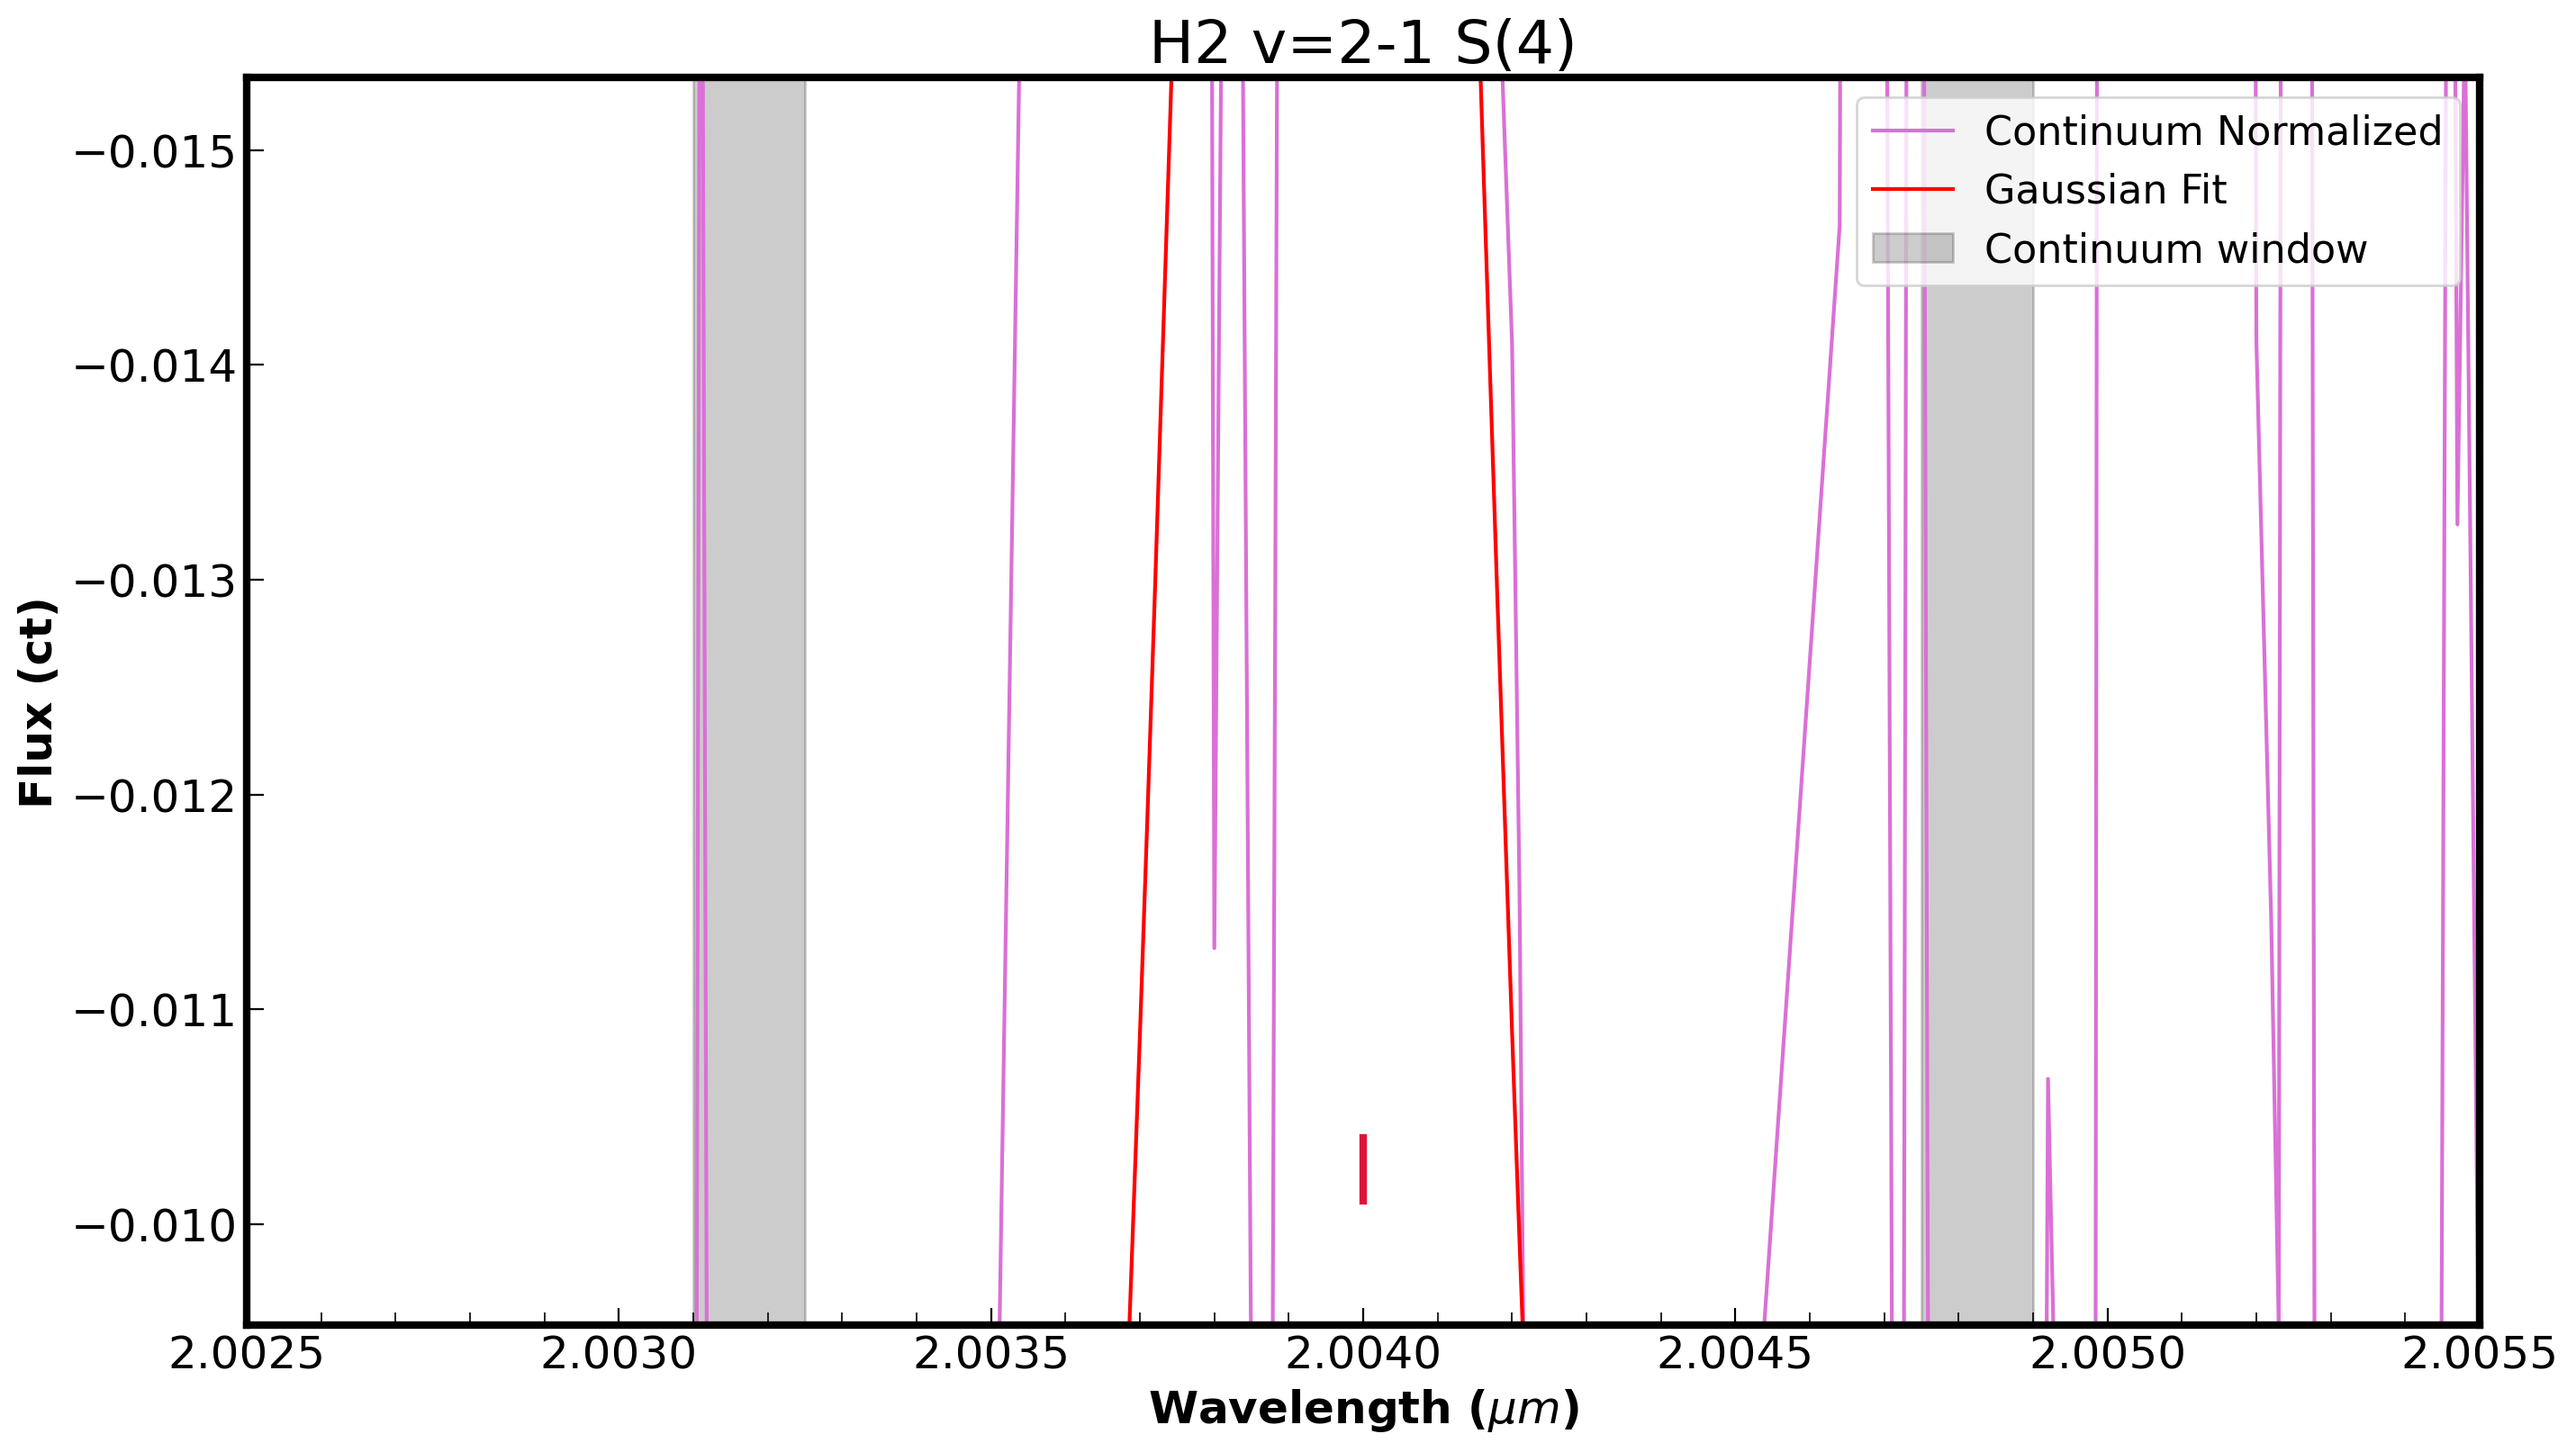

[-0.29120266  2.47865     0.7980846   0.45971124]


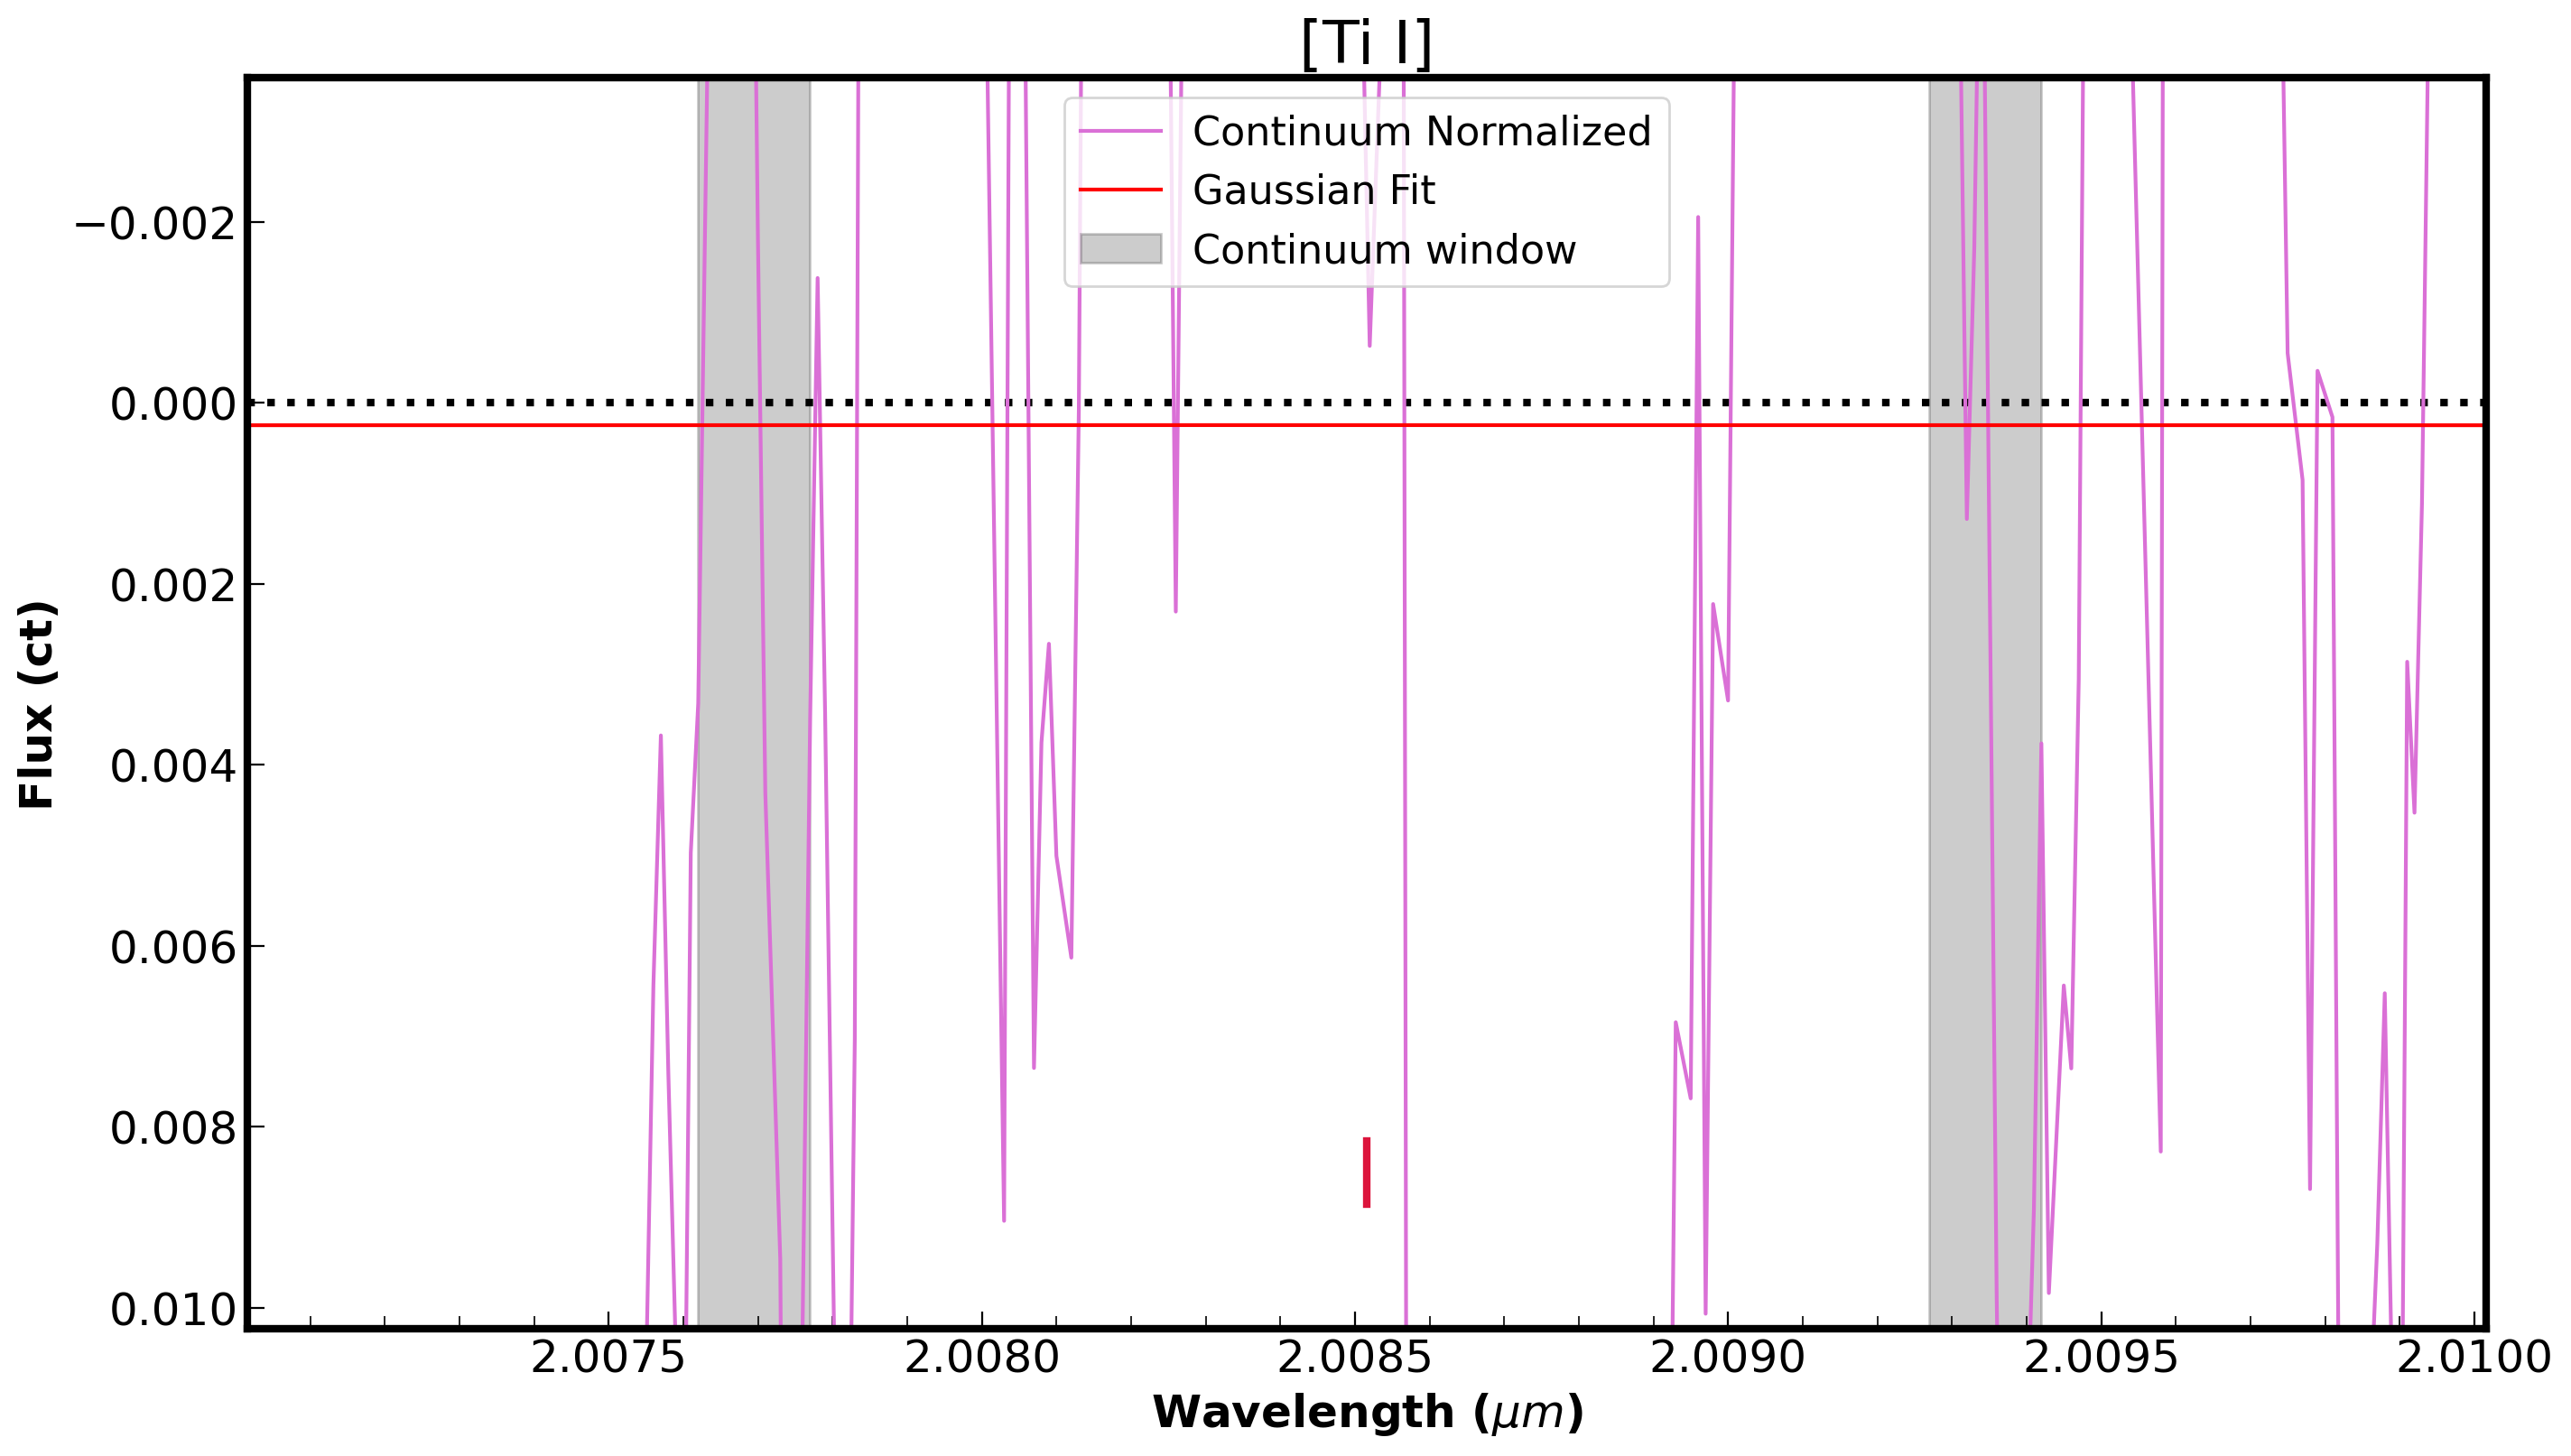

[-0.29120266  2.47865     0.7980846   0.45971124]


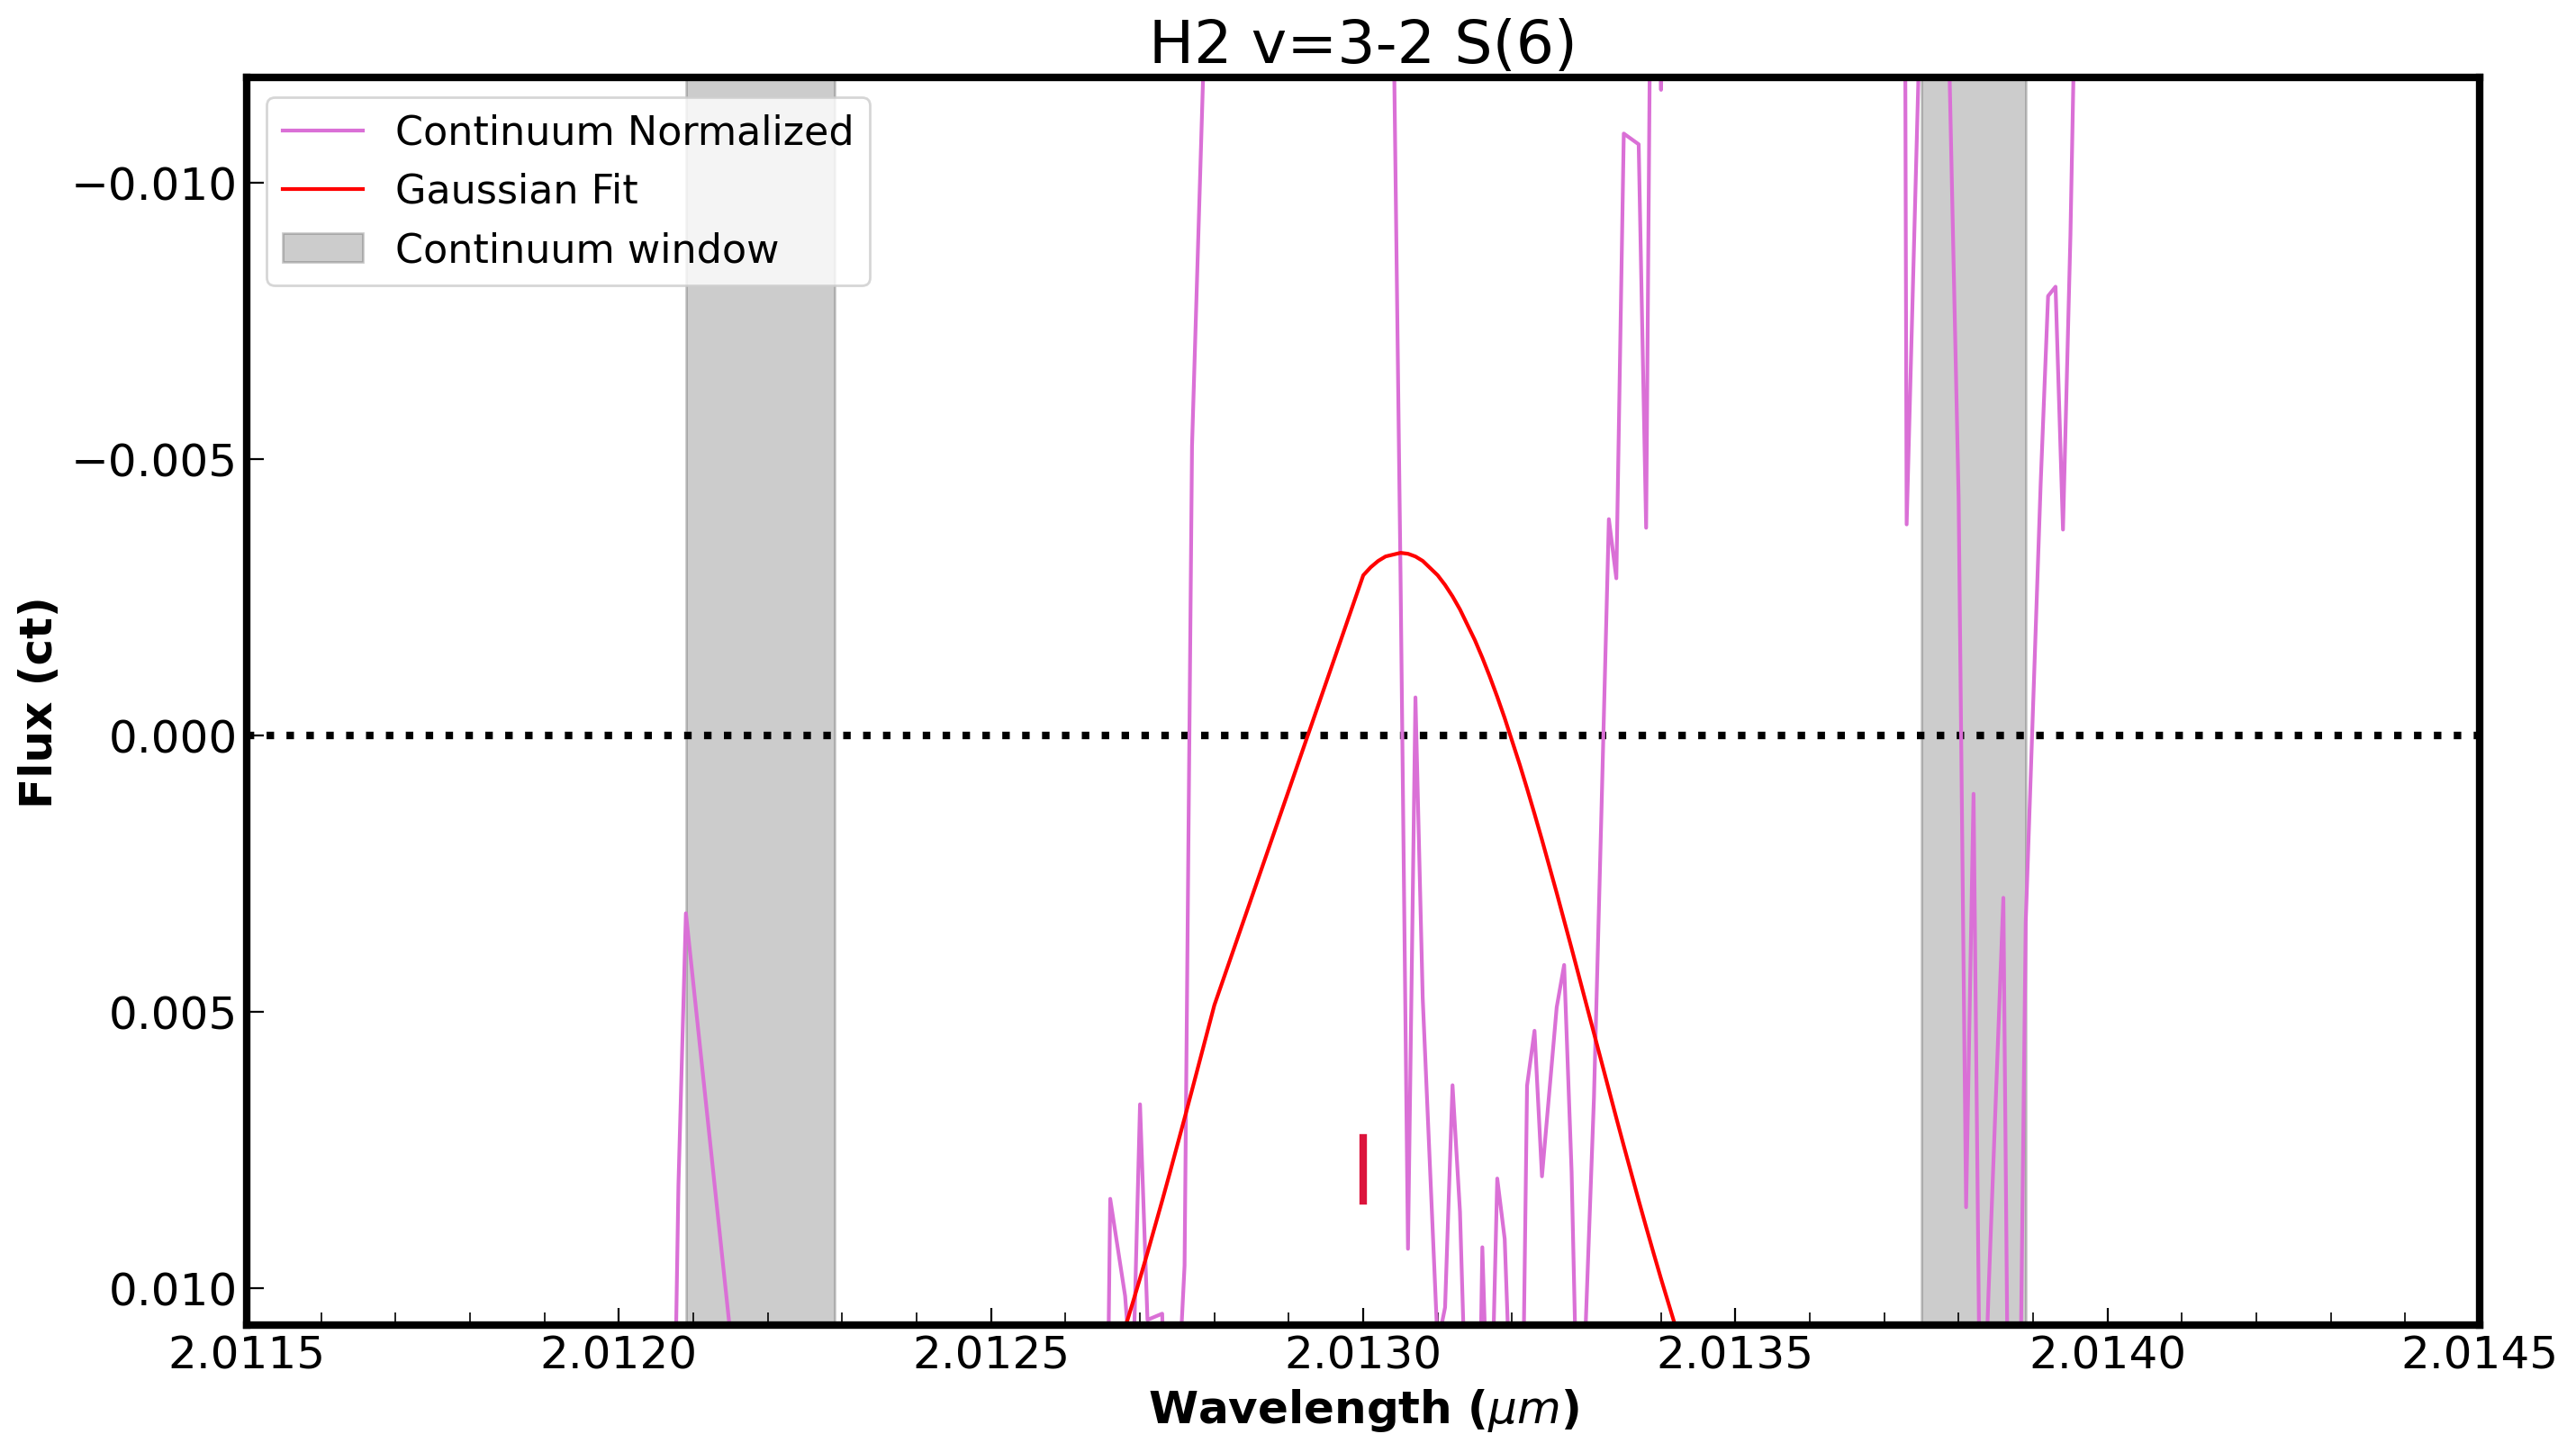

[-0.29120266  2.47865     0.7980846   0.45971124]


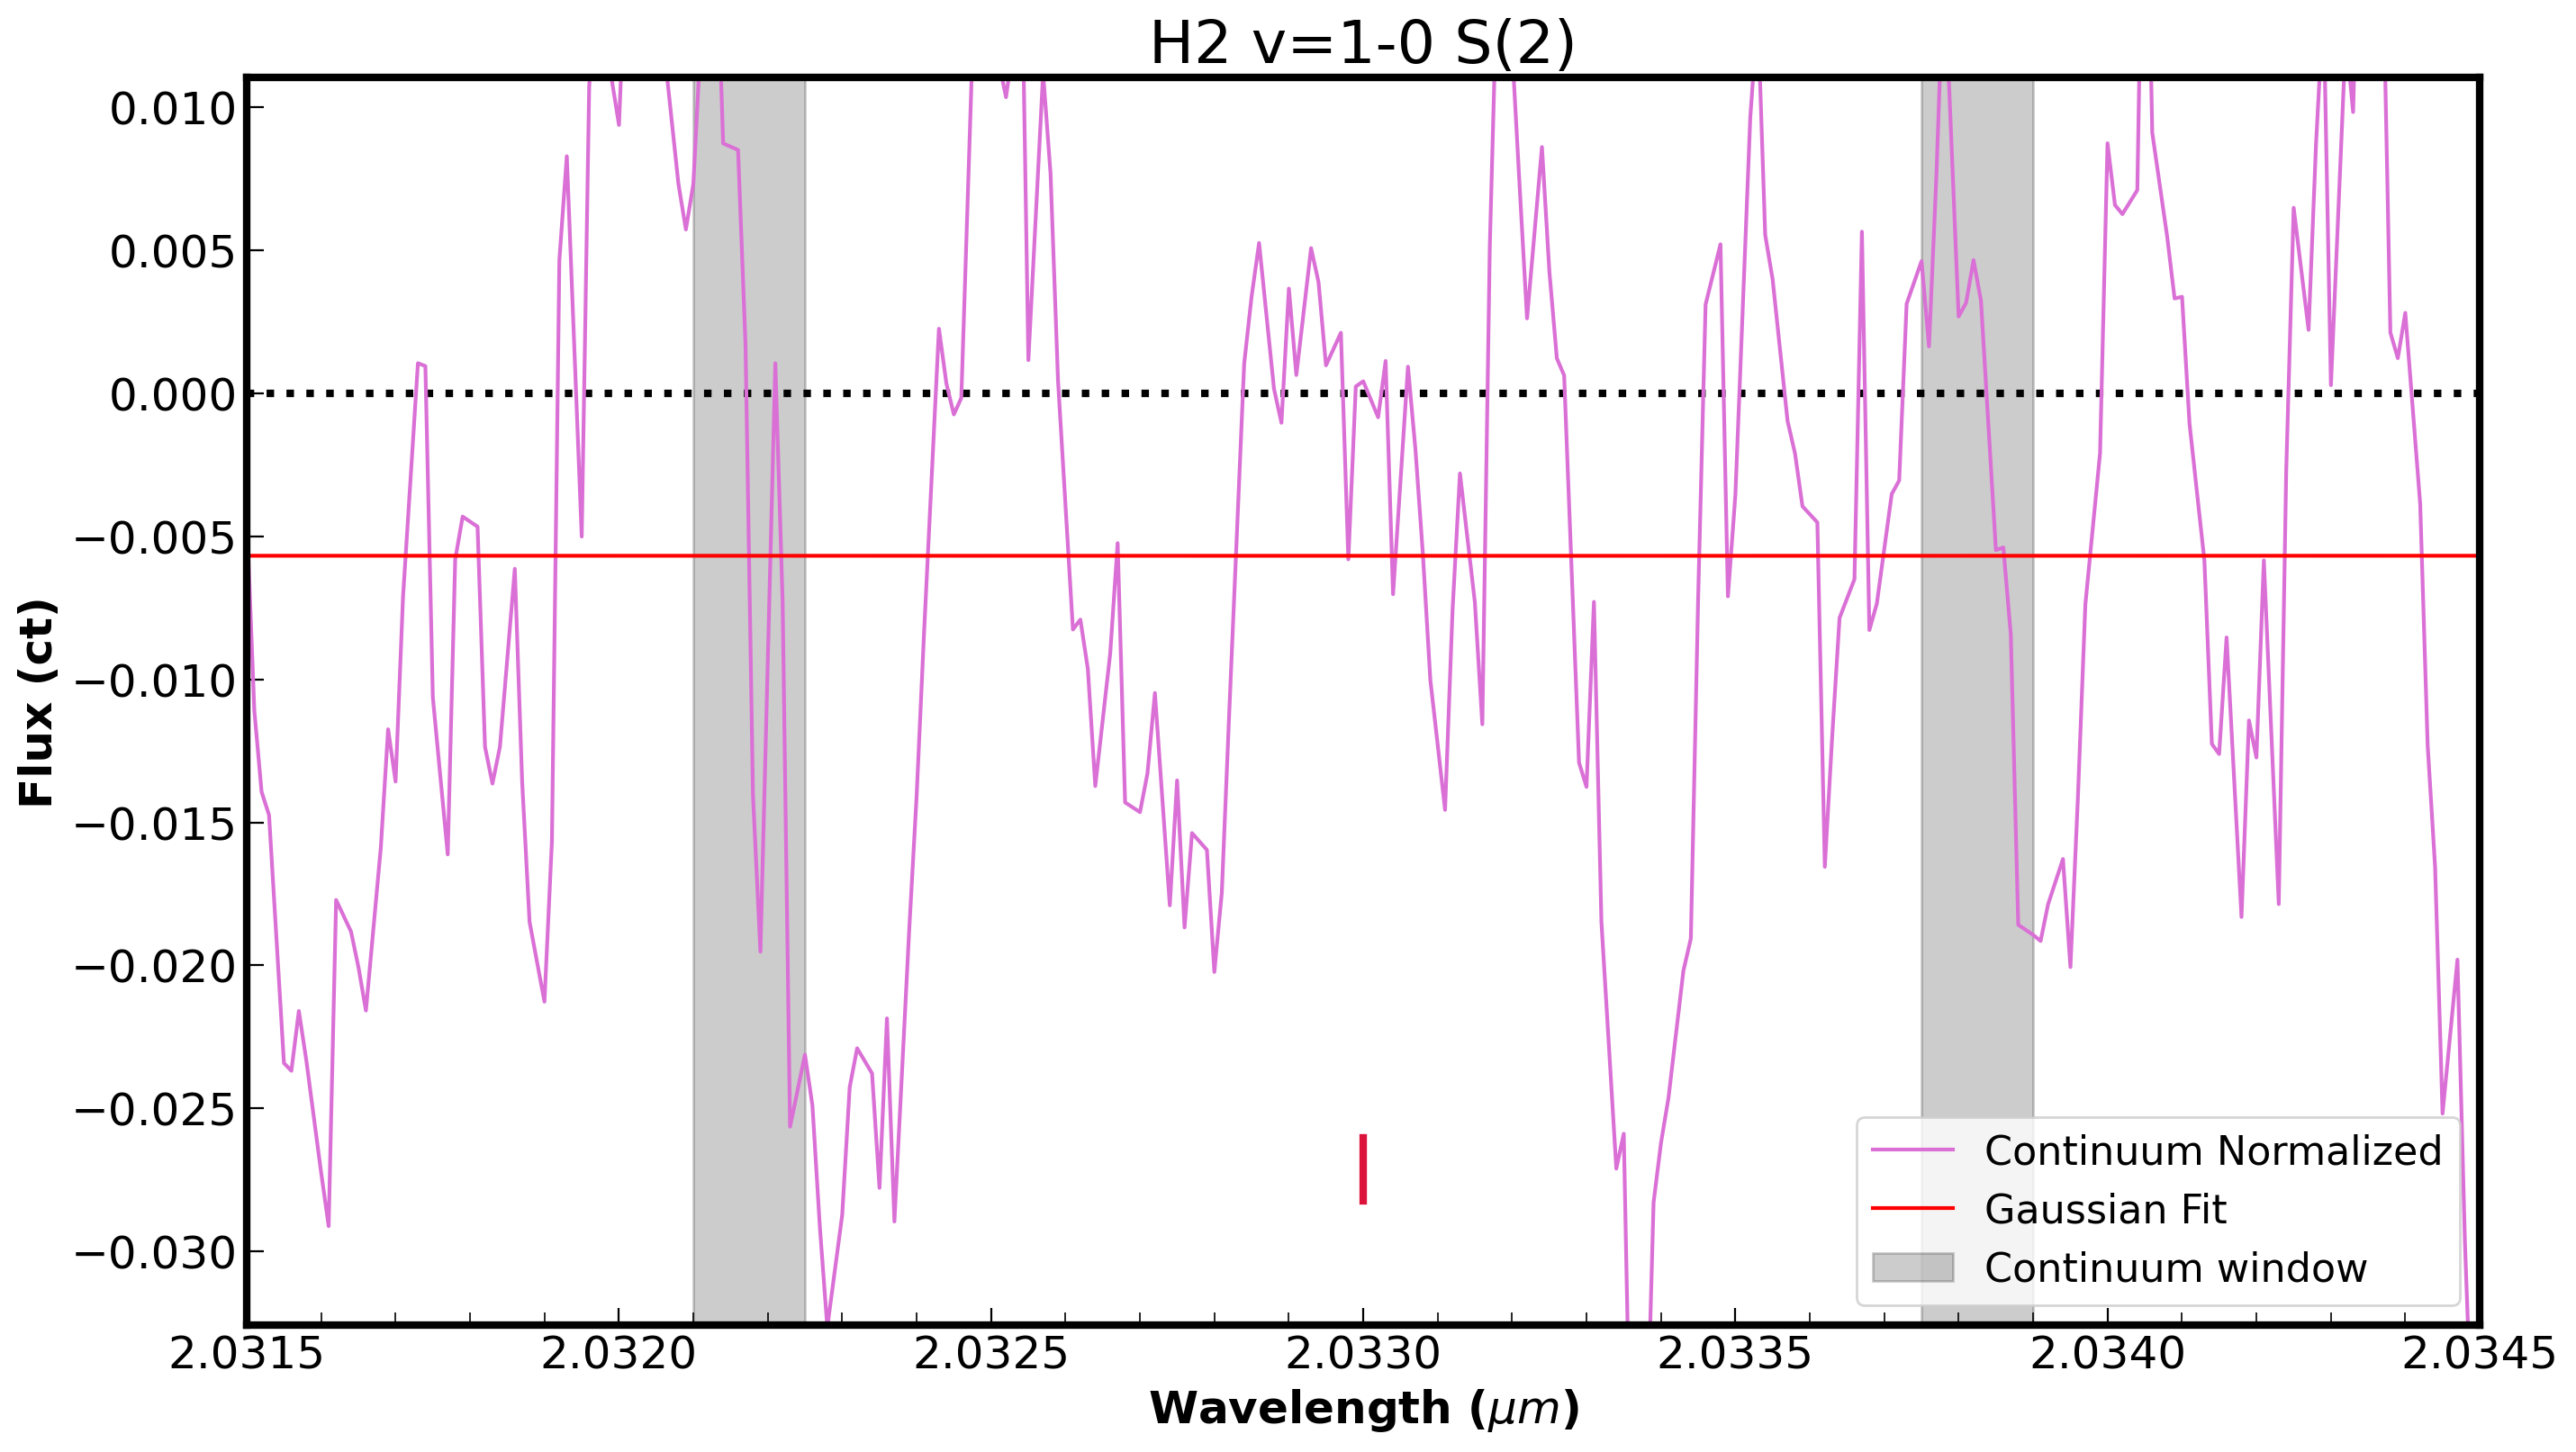

[-0.29120266  2.47865     0.7980846   0.45971124]


KeyboardInterrupt: 

In [30]:
for i in range(len(ysolines_wav)):
    line_center = ysolines_wav[i]

    continuum, contlo_min, contlo_max, conthi_min, conthi_max = ig.local_continuum_fit(wavelen,flux,line_center)

    cont_sub = flux-continuum # the polyfit continuum-subtracted flux
    cont_norm = flux/continuum # polyfit continuum normalized flux

    meancont_sub = flux-np.mean(continuum) # the mean continuum-subtracted flux
    meancont_norm = flux/np.mean(continuum) # mean continuum normalized flux
    
    # popt1, pcov1, best_model1 = ig.gauss_fit(wavelen,norm_flux,line_center,contlo_min,conthi_max) # Median normalized
    popt2, pcov2, best_model2 = ig.gauss_fit(wavelen,1-cont_norm,line_center,contlo_min,conthi_max) # (local) Continuum normalized

    fig = plt.subplots(figsize=(16,9))

    # plt.axhline(1,color='orange',lw=1,ls='-')
    plt.axhline(0,color='black',lw=3,ls=':')

    # plt.plot(wavelen,1-norm_flux,ls='-.', color='black', label='Median Normalized')
    plt.plot(wavelen,1-cont_norm, color='orchid',label='Continuum Normalized')
    # plt.plot(wavelen,1-meancont_norm,ls=':', color='darkmagenta',label='Mean Continuum Normalized')

    # plt.plot(wavelen,1-best_model1,ls='-', color='red',label='Gaussian Fit')
    plt.plot(wavelen,1-best_model2,ls='-', color='red',label='Gaussian Fit')

    # Continuum Estimation region
    plt.axvspan(wavelen[contlo_min],wavelen[contlo_max], color='black', alpha=0.2,label='Continuum window')
    plt.axvspan(wavelen[conthi_min],wavelen[conthi_max], color='black', alpha=0.2)


    for j in range(len(ysolines_wav)):
        plt.axvline(ysolines_wav[j],.1,.15,ls='-',lw=3,c='crimson')
    # for k in range(len(lines_wav)):
    #     plt.axvline(lines_wav[j],.1,.15,ls='-',lw=3,c='crimson')
        


    plt.xlim(line_center-150*ig.spec_res,line_center+150*ig.spec_res)
    # plt.ylim((1-(norm_flux[contlo_min:conthi_max]).min())-.05,(1-(norm_flux[contlo_min:conthi_max]).max())+.05)
    plt.ylim(1-(cont_norm[contlo_min:conthi_max]).min()-.05,1-(cont_norm[contlo_min:conthi_max]).max()+.05)

    plt.xlabel('Wavelength ({})'.format('$\mu m$')) 
    plt.ylabel('Flux ({})'.format("ct")) 

    plt.title(ysolines_str[i])

    plt.legend()
    plt.show()
    
    print(popt1)

In [43]:
line_center = lines_wav[16]

continuum, contlo_min, contlo_max, conthi_min, conthi_max = ig.local_continuum_fit(wavelen,flux,line_center)

cont_sub = flux-continuum # the polyfit continuum-subtracted flux
cont_norm = flux/continuum # polyfit continuum normalized flux

meancont_sub = flux-np.mean(continuum) # the mean continuum-subtracted flux
meancont_norm = flux/np.mean(continuum) # mean continuum normalized flux

popt, pcov, best_model = ig.gauss_fit(wavelen,cont_norm,line_center,contlo_min,conthi_max)

In [44]:
# initial guesses, need 4 inputs: Amplitude, center, std_dev, b (y offset)
init_params = 1-(norm_flux[contlo_min:conthi_max]).max(), line_center, 1., 0.

popt, pcov = curve_fit(f=ig.Gaussian,
                        xdata=wavelen[contlo_min:conthi_max],
                        ydata=cont_norm[contlo_min:conthi_max],
                        maxfev=30000)

best_model = gaussian_func(wavelen,*popt)

print("Best Fit Parameters:", popt)

Best Fit Parameters: [ 0.97680831  0.90986366 -0.10234695  0.96932918]


a:\Anaconda\envs\astro\envs\muler_dev\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [45]:
1-(norm_flux[contlo_min:conthi_max]).max()

-0.008084035785789423

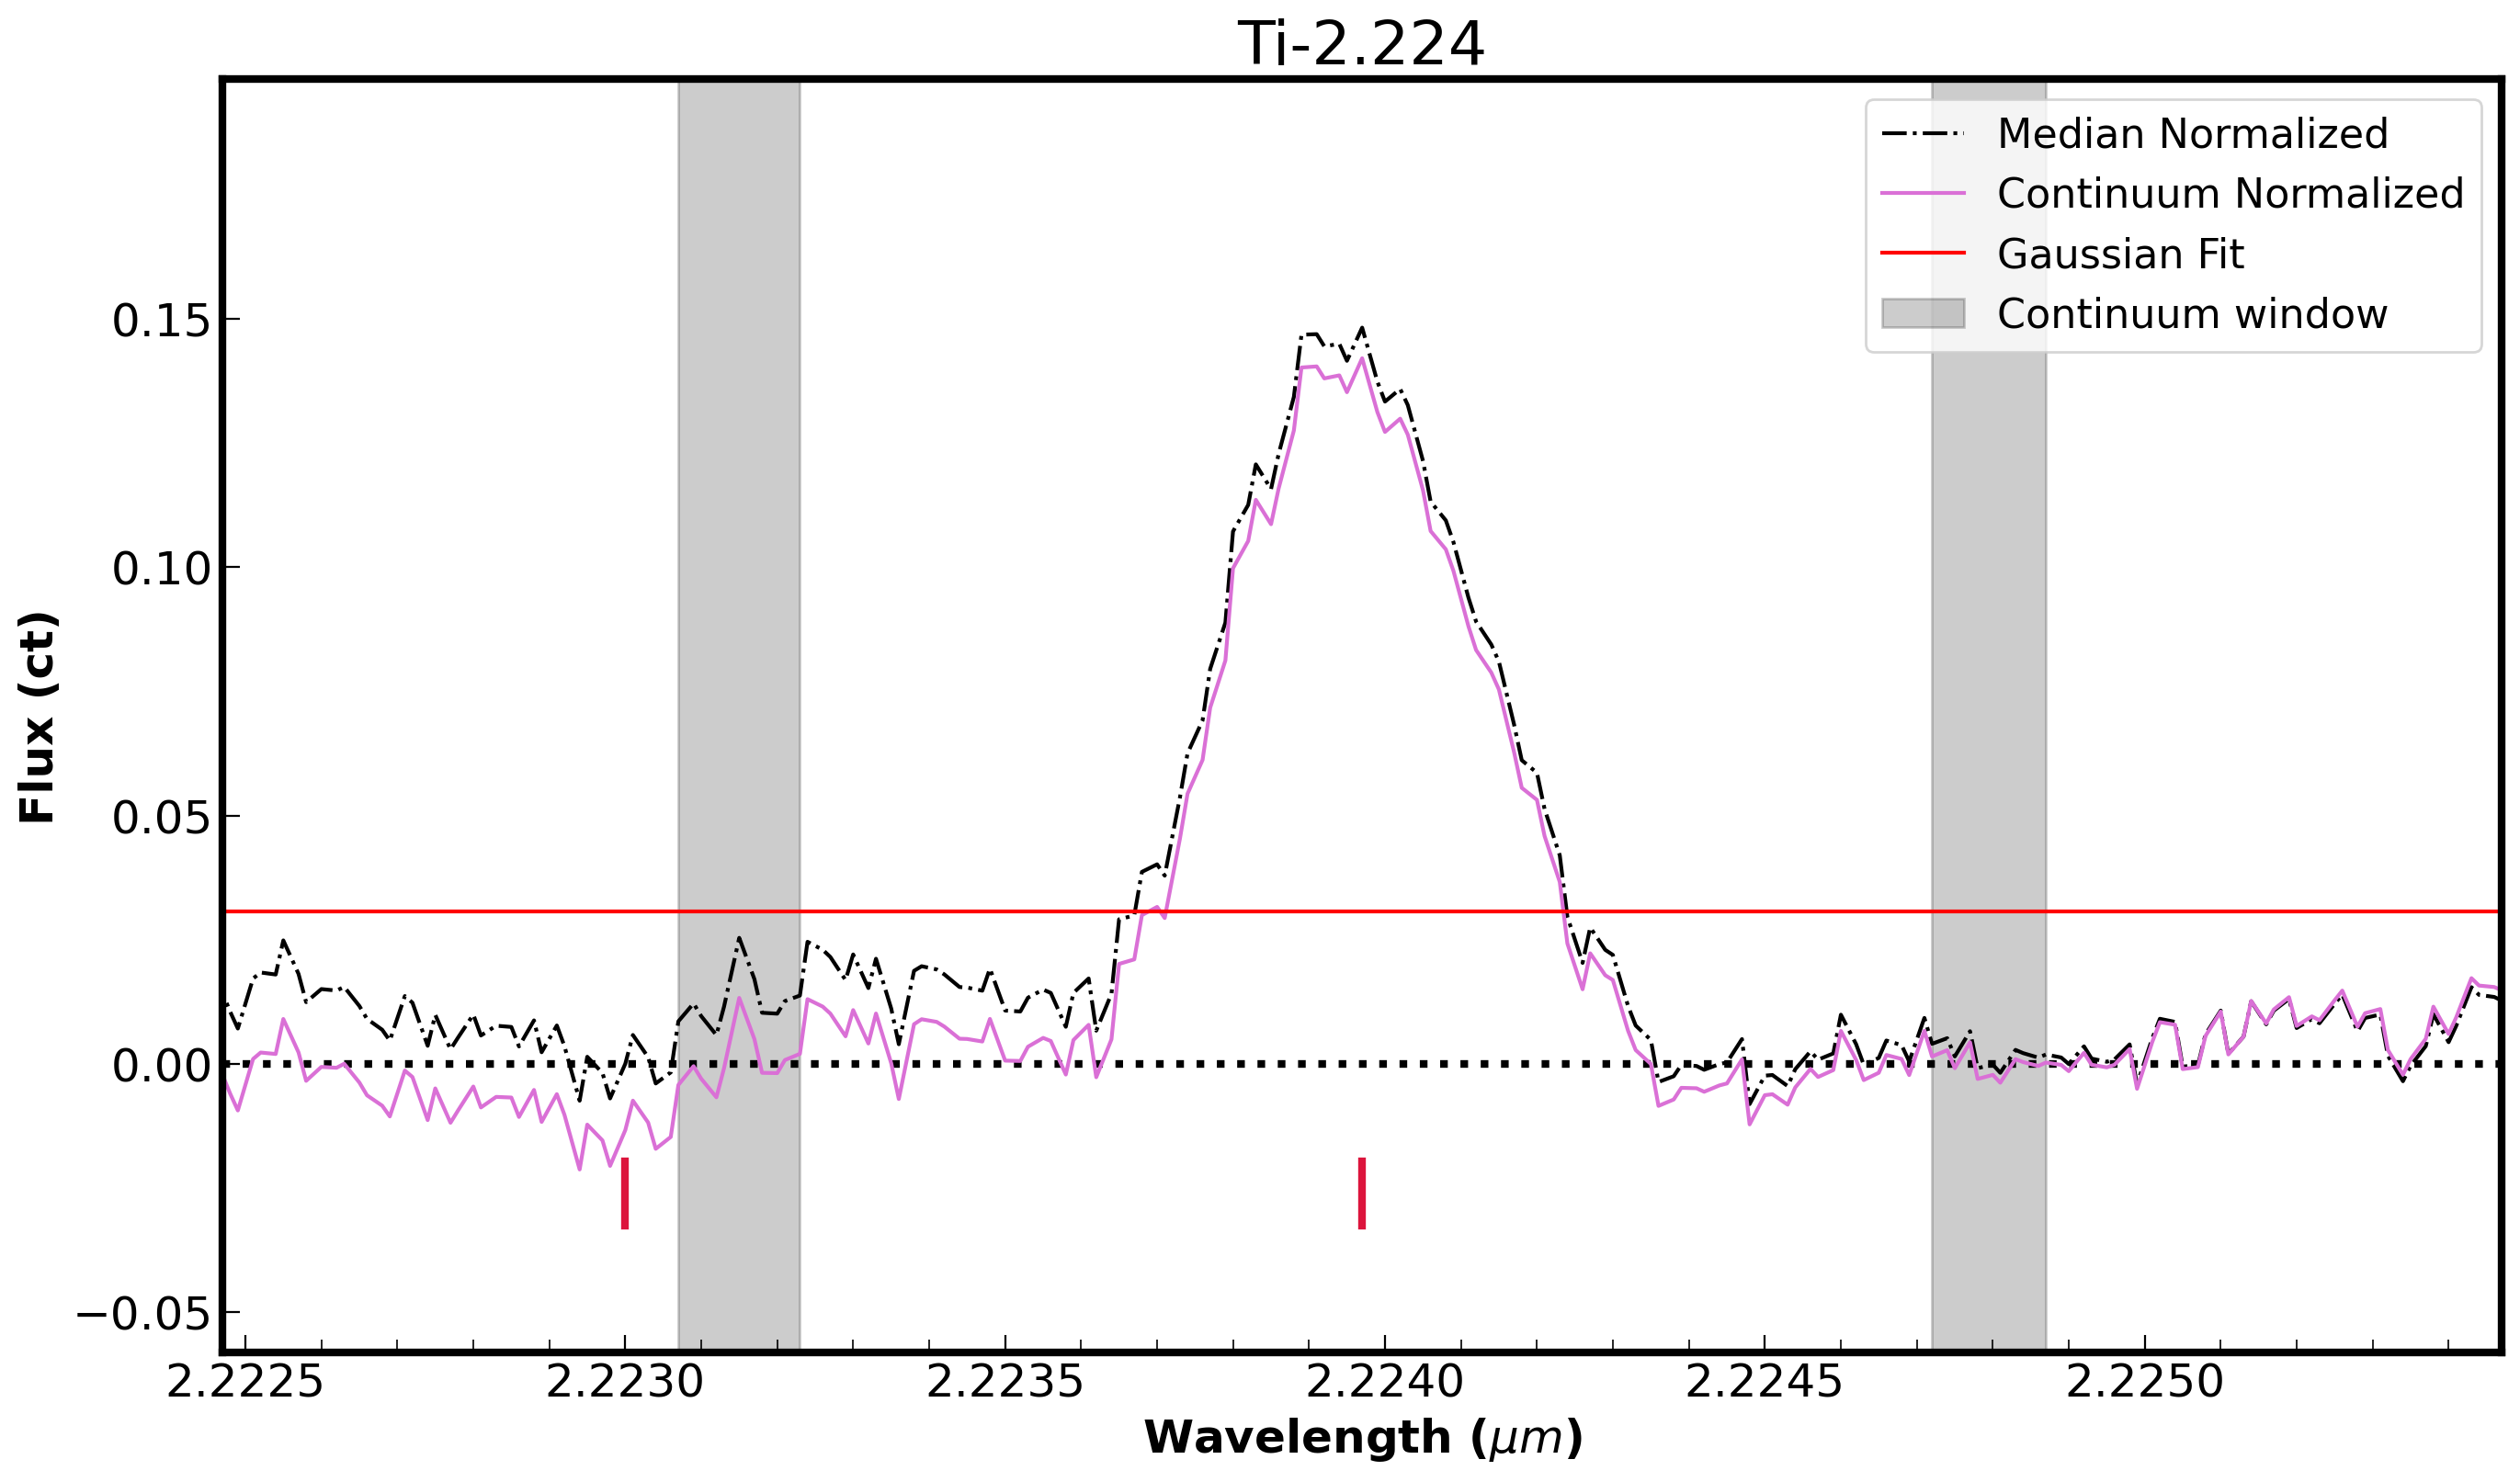

In [46]:
fig = plt.subplots(figsize=(16,9))

plt.axhline(1,color='orange',lw=1,ls='-')
plt.axhline(0,color='black',lw=3,ls=':')

plt.plot(wavelen,1-norm_flux,ls='-.', color='black', label='Median Normalized')
plt.plot(wavelen,1-cont_norm, color='orchid',label='Continuum Normalized')
# plt.plot(wavelen,1-meancont_norm,ls=':', color='darkmagenta',label='Mean Continuum Normalized')

plt.plot(wavelen,1-best_model,ls='-', color='red',label='Gaussian Fit')

# Continuum Estimation region
plt.axvspan(wavelen[contlo_min],wavelen[contlo_max], color='black', alpha=0.2,label='Continuum window')
plt.axvspan(wavelen[conthi_min],wavelen[conthi_max], color='black', alpha=0.2)


for i in range(len(lines_wav)):
    plt.axvline(lines_wav[i],.1,.15,ls='-',lw=3,c='crimson')
    plt.axvline(ysolines_wav[i],.1,.15,ls='-',lw=3,c='crimson')
    


plt.xlim(line_center-150*spec_res,line_center+150*spec_res)
# 0.05
# plt.ylim(-.5,.25)
plt.ylim((1-norm_flux[contlo_min:conthi_max]).min()-.05,
         (1-norm_flux[contlo_min:conthi_max]).max()+.05)

plt.xlabel('Wavelength ({})'.format('$\mu m$')) 
plt.ylabel('Flux ({})'.format("ct")) 

plt.title(lines_str[16])

plt.legend()
plt.show()

# Equivalent Width
---
$\begin{equation}
    W_\lambda = \int 1 - \frac{F_s}{F_c} d\lambda
\end{equation}$

In [47]:
# Integrate the Gaussian to get equivalent  width
ew1 = trapz(best_model,wavelen)
print(f'Equivalent Width: {ew1:.8f}')

Equivalent Width: 0.56394600


In [48]:
# Integration to get equivalent  width
ew2 = trapz(1-meancont_norm,wavelen)
print(f'Equivalent Width: {ew2:.8f}')

Equivalent Width: -0.12155627
